# ÌîÑÎ°úÏ†ùÌä∏ : Pretrained modelÏùò ÌôúÏö©
***
- Îç∞Ïù¥ÌÑ∞ÏÖã :  KorQuAD 1.0 
- KorQuAD Îç∞Ïù¥ÌÑ∞ÏÖãÏùÄ ÏßàÎ¨∏(question)Í≥º ÏßÄÎ¨∏(context)ÏùÑ Ï£ºÍ≥†, ÏßÄÎ¨∏ ÏòÅÏó≠ÏóêÏÑú Ï†ïÎãµ(answer)ÏùÑ Ï∞æÎèÑÎ°ù Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÏùå
***
## <Î™©Ï∞®>
### STEP 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    (1) ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∂àÎü¨Ïò§Í∏∞
    (2) Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ÌïòÍ∏∞

### STEP 2. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
    (1) ÎùÑÏñ¥Ïì∞Í∏∞ Îã®ÏúÑ Ï†ïÎ≥¥Í¥ÄÎ¶¨
    (2) Tokenize by Vocab
    (3) Improve Span
    (4) Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÎ¶¨
    (5) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Question
    (6) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Context
    (7) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Answer
    (8) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Word Cloud
    (9) Îç∞Ïù¥ÌÑ∞ Î°úÎìú
### STEP 3. LSTM Model  
### STEP 4. BERT Model
    (1)  BERT Î†àÏù¥Ïñ¥ Íµ¨ÏÑ±
    (2) BERT Î™®Îç∏ Íµ¨ÌòÑ
### STEP 5. Pretrained model ÌôúÏö©
    (1) pretrained model Î°úÎî©ÌïòÍ∏∞
    (2) pretrained model finetune ÌïòÍ∏∞
    (3) Inference ÏàòÌñâÌïòÍ∏∞
### STEP 6. ÌïôÏäµ Í≤ΩÍ≥º ÏãúÍ∞ÅÌôî ÎπÑÍµê Î∂ÑÏÑù
    (1) LSTM
    (2) Pretrained model ÎØ∏ÌôúÏö©
    (3) Pretrained model ÌôúÏö©
    (4) Í≤∞Í≥º Î∂ÑÏÑù : Í∑∏ÎûòÌîÑ, ÏõåÎìúÌÅ¥ÎùºÏö∞Îìú
### ü§îÌöåÍ≥†ü§î
### Reference

***

# STEP 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
## (1) ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∂àÎü¨Ïò§Í∏∞

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## (2) Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ÌïòÍ∏∞
- print_json_tree() : KorQuAD Îç∞Ïù¥ÌÑ∞Ï≤òÎüº json Ìè¨Îß∑ÏúºÎ°ú Ïù¥Î£®Ïñ¥ÏßÑ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Î¶¨Ïä§Ìä∏Ïùò Ï≤´ Î≤àÏß∏ ÏïÑÏù¥ÌÖúÏùò Ïã§Ï†ú ÎÇ¥Ïö©ÏùÑ Í∞ÑÎã®Ìûà ÌôïÏù∏ÌïòÎäîÎç∞ Ïú†Ïö©

In [2]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list ÌòïÌÉúÏùò itemÏùÄ Ï≤´Î≤àÏß∏ itemÎßå Ï∂úÎ†•
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

# ÌõàÎ†®Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: ÍµêÌñ•Í≥°
        - answer_start: 54
      - id: 6566495-0-0
      - question: Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏Î•º ÏùΩÍ≥† Î¨¥ÏóáÏùÑ Ïì∞Í≥†Ïûê ÌñàÎäîÍ∞Ä?
    - context: 1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ Ï≤òÏùå ÏùΩÍ≥† Í∑∏ ÎÇ¥Ïö©Ïóê ÎßàÏùåÏù¥ ÎÅåÎ†§ Ïù¥Î•º ÏÜåÏû¨Î°ú Ìï¥ÏÑú ÌïòÎÇòÏùò ÍµêÌñ•Í≥°ÏùÑ Ïì∞Î†§Îäî ÎúªÏùÑ Í∞ñÎäîÎã§. Ïù¥ ÏãúÍ∏∞ Î∞îÍ∑∏ÎÑàÎäî 1838ÎÖÑÏóê Îπõ ÎèÖÏ¥âÏúºÎ°ú ÏÇ∞Ï†ÑÏàòÏ†ÑÏùÑ Îã§ Í±≤ÏùÄ ÏÉÅÌô©Ïù¥Îùº Ï¢åÏ†àÍ≥º Ïã§ÎßùÏóê Í∞ÄÎìùÌñàÏúºÎ©∞ Î©îÌîºÏä§ÌÜ†Ìé†Î†àÏä§Î•º ÎßåÎÇòÎäî ÌååÏö∞Ïä§Ìä∏Ïùò Ïã¨Í≤ΩÏóê Í≥µÍ∞êÌñàÎã§Í≥† ÌïúÎã§. ÎòêÌïú ÌååÎ¶¨ÏóêÏÑú ÏïÑÎ∏åÎÑ§ÌÅ¨Ïùò ÏßÄÌúòÎ°ú ÌååÎ¶¨ ÏùåÏïÖÏõê Í¥ÄÌòÑÏïÖÎã®Ïù¥ Ïó∞Ï£ºÌïòÎäî Î≤†ÌÜ†Î≤§Ïùò ÍµêÌñ•Í≥° 9Î≤àÏùÑ Îì£Í≥† ÍπäÏùÄ Í∞êÎ™ÖÏùÑ Î∞õÏïòÎäîÎç∞, Ïù¥Í≤ÉÏù¥ Ïù¥Îì¨Ìï¥ 1ÏõîÏóê ÌååÏö∞Ïä§Ìä∏Ïùò ÏÑúÍ≥°ÏúºÎ°ú Ïì∞Ïó¨ÏßÑ Ïù¥ ÏûëÌíàÏóê Ï°∞Í∏àÏù¥ÎùºÎèÑ ÏòÅÌñ•ÏùÑ ÎÅºÏ≥§ÏúºÎ¶¨ÎùºÎäî Í≤ÉÏùÄ ÏùòÏã¨Ìï† Ïó¨ÏßÄÍ∞Ä ÏóÜÎã§. Ïó¨Í∏∞Ïùò 

In [4]:
# Í≤ÄÏ¶ùÎç∞Ïù¥ÌÑ∞ ÌôïÏù∏
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989ÎÖÑ 2Ïõî 15Ïùº
        - answer_start: 0
      - id: 6548850-0-0
      - question: ÏûÑÏ¢ÖÏÑùÏù¥ Ïó¨ÏùòÎèÑ ÎÜçÎØº Ìè≠Î†• ÏãúÏúÑÎ•º Ï£ºÎèÑÌïú ÌòêÏùòÎ°ú ÏßÄÎ™ÖÏàòÎ∞∞ Îêú ÎÇ†ÏùÄ?
    - context: 1989ÎÖÑ 2Ïõî 15Ïùº Ïó¨ÏùòÎèÑ ÎÜçÎØº Ìè≠Î†• ÏãúÏúÑÎ•º Ï£ºÎèÑÌïú ÌòêÏùò(Ìè≠Î†•ÌñâÏúÑÎì±Ï≤òÎ≤åÏóêÍ¥ÄÌïúÎ≤ïÎ•†ÏúÑÎ∞ò)ÏúºÎ°ú ÏßÄÎ™ÖÏàòÎ∞∞ÎêòÏóàÎã§. 1989ÎÖÑ 3Ïõî 12Ïùº ÏÑúÏö∏ÏßÄÎ∞©Í≤ÄÏ∞∞Ï≤≠ Í≥µÏïàÎ∂ÄÎäî ÏûÑÏ¢ÖÏÑùÏùò ÏÇ¨Ï†ÑÍµ¨ÏÜçÏòÅÏû•ÏùÑ Î∞úÎ∂ÄÎ∞õÏïòÎã§. Í∞ôÏùÄ Ìï¥ 6Ïõî 30Ïùº ÌèâÏñëÏ∂ïÏ†ÑÏóê ÏûÑÏàòÍ≤ΩÏùÑ ÎåÄÌëúÎ°ú ÌååÍ≤¨ÌïòÏó¨ Íµ≠Í∞ÄÎ≥¥ÏïàÎ≤ïÏúÑÎ∞ò ÌòêÏùòÍ∞Ä Ï∂îÍ∞ÄÎêòÏóàÎã§. Í≤ΩÏ∞∞ÏùÄ 12Ïõî 18Ïùº~20Ïùº ÏÇ¨Ïù¥ ÏÑúÏö∏ Í≤ΩÌù¨ÎåÄÌïôÍµêÏóêÏÑú ÏûÑÏ¢ÖÏÑùÏù¥ ÏÑ±Î™Ö Î∞úÌëúÎ•º Ï∂îÏßÑÌïòÍ≥† ÏûàÎã§Îäî Ï≤©Î≥¥Î•º ÏûÖÏàòÌñàÍ≥†, 12Ïõî 18Ïùº Ïò§Ï†Ñ 7Ïãú 40Î∂Ñ Í≤Ω Í∞ÄÏä§Ï¥ùÍ≥º Ï†ÑÏûêÎ¥âÏúºÎ°ú Î¨¥Ïû•Ìïú ÌäπÍ≥µÏ°∞ Î∞è ÎåÄÍ≥µÍ≥º ÏßÅÏõê 12Î™Ö Îì± 22Î™ÖÏùò ÏÇ¨Î≥µ Í≤ΩÏ∞∞ÏùÑ ÏäπÏö©Ï∞® 8ÎåÄÏóê ÎÇòÎàÑÏñ¥ Í≤ΩÌù¨ÎåÄÌï

- json.dumps() : json Îç∞Ïù¥ÌÑ∞Ïùò Ïã§Ï†ú ÌòïÌÉú ÌôïÏù∏

In [5]:
print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False))

{
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "ÍµêÌñ•Í≥°",
              "answer_start": 54
            }
          ],
          "id": "6566495-0-0",
          "question": "Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏Î•º ÏùΩÍ≥† Î¨¥ÏóáÏùÑ Ïì∞Í≥†Ïûê ÌñàÎäîÍ∞Ä?"
        },
        {
          "answers": [
            {
              "text": "1ÏïÖÏû•",
              "answer_start": 421
            }
          ],
          "id": "6566495-0-1",
          "question": "Î∞îÍ∑∏ÎÑàÎäî ÍµêÌñ•Í≥° ÏûëÍ≥°ÏùÑ Ïñ¥ÎîîÍπåÏßÄ Ïì¥ Îí§Ïóê Ï§ëÎã®ÌñàÎäîÍ∞Ä?"
        },
        {
          "answers": [
            {
              "text": "Î≤†ÌÜ†Î≤§Ïùò ÍµêÌñ•Í≥° 9Î≤à",
              "answer_start": 194
            }
          ],
          "id": "6566495-0-2",
          "question": "Î∞îÍ∑∏ÎÑàÍ∞Ä ÌååÏö∞Ïä§Ìä∏ ÏÑúÍ≥°ÏùÑ Ïì∏ Îïå Ïñ¥Îñ§ Í≥°Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏïòÎäîÍ∞Ä?"
        },
        {
          "answers": [
            {
              "text": "ÌååÏö∞Ïä§Ìä∏",

# STEP 2. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
## (1) ÎùÑÏñ¥Ïì∞Í∏∞ Îã®ÏúÑ Ï†ïÎ≥¥Í¥ÄÎ¶¨
- SQuAD, KorQuAD Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Î™®Îç∏ÏùÑ Íµ¨ÏÑ±ÌïòÍ∏∞ ÏúÑÌïú Ï†ÑÏ≤òÎ¶¨Îäî Îã§Î•∏ ÏûêÏó∞Ïñ¥ ÌÉúÏä§ÌÅ¨ÏôÄ Ï†ÑÍ∑ºÎ∞©ÏãùÏù¥ Ï°∞Í∏à Îã§Î¶Ñ

In [6]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [7]:
# whitespaceÍ∞Ä 2Í∞úÏù∏ Í≤ΩÏö∞Î•º Ï≤òÎ¶¨Ìï¥Ïïº Ìï®

string1 = '1839ÎÖÑ ÌååÏö∞Ïä§Ìä∏Î•º ÏùΩÏóàÎã§.'
string2 = '1839ÎÖÑ  ÌååÏö∞Ïä§Ìä∏Î•º ÏùΩÏóàÎã§.'
string1[6:10], string2[7:11]

('ÌååÏö∞Ïä§Ìä∏', 'ÌååÏö∞Ïä§Ìä∏')

- ÏúÑ Îëê Î¨∏Ïû•Ïóê ÎåÄÌï¥ Í∏ÄÏûêÎ≥ÑÎ°ú ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º Í¥ÄÎ¶¨Ìï¥ Ï£ºÎ†§Î©¥ Îã§ÏùåÍ≥º Í∞ôÏù¥ ÏïΩÍ∞Ñ Îã§Î•¥Í≤å Ï≤òÎ¶¨Îê† Í≤ÉÏûÖÎãàÎã§.

In [8]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# Ï≤´Î≤àÏß∏ Î¨∏Ïû•(string1)Ïóê ÎåÄÌï¥ ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º ÌëúÏãú
for c in string1:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'ÎÖÑ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0]
' ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0, 0]
'Ìåå' : ['1839ÎÖÑ', 'Ìåå'] : [0, 0, 0, 0, 0, 0, 1]
'Ïö∞' : ['1839ÎÖÑ', 'ÌååÏö∞'] : [0, 0, 0, 0, 0, 0, 1, 1]
'Ïä§' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§'] : [0, 0, 0, 0, 0, 0, 1, 1, 1]
'Ìä∏' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'Î•º' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'ÏùΩ' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩ'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'Ïóà' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóà'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'Îã§' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


In [9]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# ÎëêÎ≤àÏß∏ Î¨∏Ïû•(string2)Ïóê ÎåÄÌï¥ ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º ÌëúÏãú
for c in string2:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'ÎÖÑ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0]
' ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0, 0]
' ' : ['1839ÎÖÑ'] : [0, 0, 0, 0, 0, 0, 0]
'Ìåå' : ['1839ÎÖÑ', 'Ìåå'] : [0, 0, 0, 0, 0, 0, 0, 1]
'Ïö∞' : ['1839ÎÖÑ', 'ÌååÏö∞'] : [0, 0, 0, 0, 0, 0, 0, 1, 1]
'Ïä§' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
'Ìä∏' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'Î•º' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'ÏùΩ' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩ'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'Ïóà' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóà'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'Îã§' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1

- ÏúÑ Í∏∞Îä•ÏùÑ Ìï®ÏàòÎ°ú Ï†ïÎ¶¨Ìï¥ÎëêÍ≤†Îã§.

In [10]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

- ÏúÑ Ìï®ÏàòÎ•º Ï†ÅÏö©Ìï¥Î¥Ñ

In [11]:
# Ï≤´Î≤àÏß∏ Î¨∏Ïû•(string1)Ïóê ÎåÄÌï¥ ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º ÌëúÏãú
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'ÎÖÑ' : 0
' ' : 0
'Ìåå' : 1
'Ïö∞' : 1
'Ïä§' : 1
'Ìä∏' : 1
'Î•º' : 1
' ' : 1
'ÏùΩ' : 2
'Ïóà' : 2
'Îã§' : 2
'.' : 2


(['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [12]:
# ÎëêÎ≤àÏß∏ Î¨∏Ïû•(string2)Ïóê ÎåÄÌï¥ ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º ÌëúÏãú
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'ÎÖÑ' : 0
' ' : 0
' ' : 0
'Ìåå' : 1
'Ïö∞' : 1
'Ïä§' : 1
'Ìä∏' : 1
'Î•º' : 1
' ' : 1
'ÏùΩ' : 2
'Ïóà' : 2
'Îã§' : 2
'.' : 2


(['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.'],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

## (2) Tokenize by Vocab
- Subword Segmentation :  'ÏùΩÏóàÎã§'Î•º 'ÏùΩ'+'ÏóàÎã§' Î°ú ÎÇòÎàÑÏñ¥ÏÑú Ï≤òÎ¶¨ÌïòÎäî Î∞©Ïãù
- Íµ¨Í∏ÄÏóêÏÑú Ïò§ÌîàÏÜåÏä§Î°ú Ï†úÍ≥µÌïòÎäî SentencePiece Î™®Îç∏ÏùÄ ÌååÏù¥Ïç¨ÏóêÏÑú ÏÜêÏâΩÍ≤å ÏÇ¨Ïö© Í∞ÄÎä•
- BERTÏóêÎäî WordPiece Î™®Îç∏ ÏÇ¨Ïö©Ïù¥ ÏùºÎ∞òÏ†Å
- '_' ÌëúÏãúÎäî ÏïûÎ∂ÄÎ∂ÑÏù¥ Í≥µÎ∞±Ïù¥ÎùºÎäî Îúª

In [13]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

# wordÎ•º subwordÎ°ú Î≥ÄÍ≤ΩÌïòÎ©¥ÏÑú index Ï†ÄÏû•
word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens):
    word_to_token.append(len(context_tokens))
    tokens = vocab.encode_as_pieces(word)  # SentencePieceÎ•º ÏÇ¨Ïö©Ìï¥ SubwordÎ°ú Ï™ºÍ∞≠ÎãàÎã§.
    for token in tokens:
        context_tokens.append(token)

context_tokens, word_to_token

(['‚ñÅ1839', 'ÎÖÑ', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'Î•º', '‚ñÅÏùΩ', 'ÏóàÎã§', '.'], [0, 2, 5])

In [14]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [15]:
print(word_tokens)  # Ï≤òÎ¶¨Ìï¥Ïïº Ìï† word Îã®ÏúÑ ÏûÖÎ†•

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token   # Subword Îã®ÏúÑÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥º

['1839ÎÖÑ', 'ÌååÏö∞Ïä§Ìä∏Î•º', 'ÏùΩÏóàÎã§.']


(['‚ñÅ1839', 'ÎÖÑ', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'Î•º', '‚ñÅÏùΩ', 'ÏóàÎã§', '.'], [0, 2, 5])

## (3) Improve Span
- Ï†ïÎãµÏóê Ìï¥ÎãπÌïòÎäî ÏßÄÎ¨∏ ÏòÅÏó≠ÏùÑ Ï†ïÌôïÌûà Ï∞æÏïÑÎÇ¥Îäî Í≤ÉÏù¥ Ï†ÑÏ≤òÎ¶¨Ïùò ÌïµÏã¨Ï†ÅÏù∏ ÏûëÏóÖ

In [16]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_textÏóê Ìï¥ÎãπÌïòÎäî context ÏòÅÏó≠ÏùÑ Ï†ïÌôïÌûà Ï∞æÏïÑÎÇ¥Ïïº Ìï©ÎãàÎã§. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ Ï≤òÏùå ÏùΩÍ≥† Í∑∏ ÎÇ¥Ïö©Ïóê ÎßàÏùåÏù¥ ÎÅåÎ†§ Ïù¥Î•º ÏÜåÏû¨Î°ú Ìï¥ÏÑú ÌïòÎÇòÏùò ÍµêÌñ•Í≥°ÏùÑ Ïì∞Î†§Îäî ÎúªÏùÑ Í∞ñÎäîÎã§. Ïù¥ ÏãúÍ∏∞ Î∞îÍ∑∏ÎÑàÎäî 1838ÎÖÑÏóê Îπõ ÎèÖÏ¥âÏúºÎ°ú ÏÇ∞Ï†ÑÏàòÏ†ÑÏùÑ Îã§ Í±≤ÏùÄ ÏÉÅÌô©Ïù¥Îùº Ï¢åÏ†àÍ≥º Ïã§ÎßùÏóê Í∞ÄÎìùÌñàÏúºÎ©∞ Î©îÌîºÏä§ÌÜ†Ìé†Î†àÏä§Î•º ÎßåÎÇòÎäî ÌååÏö∞Ïä§Ìä∏Ïùò Ïã¨Í≤ΩÏóê Í≥µÍ∞êÌñàÎã§Í≥† ÌïúÎã§. ÎòêÌïú ÌååÎ¶¨ÏóêÏÑú ÏïÑÎ∏åÎÑ§ÌÅ¨Ïùò ÏßÄÌúòÎ°ú ÌååÎ¶¨ ÏùåÏïÖÏõê Í¥ÄÌòÑÏïÖÎã®Ïù¥ Ïó∞Ï£ºÌïòÎäî Î≤†ÌÜ†Î≤§Ïùò ÍµêÌñ•Í≥° 9Î≤àÏùÑ Îì£Í≥† ÍπäÏùÄ Í∞êÎ™ÖÏùÑ Î∞õÏïòÎäîÎç∞, Ïù¥Í≤ÉÏù¥ Ïù¥Îì¨Ìï¥ 1ÏõîÏóê ÌååÏö∞Ïä§Ìä∏Ïùò ÏÑúÍ≥°ÏúºÎ°ú Ïì∞Ïó¨ÏßÑ Ïù¥ ÏûëÌíàÏóê Ï°∞Í∏àÏù¥ÎùºÎèÑ ÏòÅÌñ•ÏùÑ ÎÅºÏ≥§ÏúºÎ¶¨ÎùºÎäî Í≤ÉÏùÄ ÏùòÏã¨Ìï† Ïó¨ÏßÄÍ∞Ä ÏóÜÎã§. Ïó¨Í∏∞Ïùò ÎùºÎã®Ï°∞ Ï°∞ÏÑ±Ïùò Í≤ΩÏö∞ÏóêÎèÑ Í∑∏Ïùò Ï†ÑÍ∏∞Ïóê Ï†ÅÌòÄ ÏûàÎäî Í≤ÉÏ≤òÎüº Îã®ÏàúÌïú Ï†ïÏã†Ï†Å ÌîºÎ°úÎÇò Ïã§ÏùòÍ∞Ä Î∞òÏòÅÎêú Í≤ÉÏù¥ ÏïÑÎãàÎùº Î≤†ÌÜ†Î≤§Ïùò Ìï©Ï∞ΩÍµêÌñ•Í≥° Ï°∞ÏÑ±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÄ Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. Í∑∏Î†áÍ≤å ÍµêÌñ•Í≥° ÏûëÍ≥°ÏùÑ 1839ÎÖÑÎ∂ÄÌÑ∞ 40ÎÖÑÏóê Í±∏Ï

In [17]:
# contextÎ•º ÎùÑÏñ¥Ïì∞Í∏∞(word) Îã®ÏúÑÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥ºÎ•º ÏÇ¥Ìé¥Î¥ÖÎãàÎã§. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['1839ÎÖÑ', 'Î∞îÍ∑∏ÎÑàÎäî', 'Í¥¥ÌÖåÏùò', 'ÌååÏö∞Ïä§Ìä∏ÏùÑ', 'Ï≤òÏùå', 'ÏùΩÍ≥†', 'Í∑∏', 'ÎÇ¥Ïö©Ïóê', 'ÎßàÏùåÏù¥', 'ÎÅåÎ†§', 'Ïù¥Î•º', 'ÏÜåÏû¨Î°ú', 'Ìï¥ÏÑú', 'ÌïòÎÇòÏùò', 'ÍµêÌñ•Í≥°ÏùÑ', 'Ïì∞Î†§Îäî', 'ÎúªÏùÑ', 'Í∞ñÎäîÎã§.', 'Ïù¥', 'ÏãúÍ∏∞']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ')

In [18]:
# ÎùÑÏñ¥Ïì∞Í∏∞(word) Îã®ÏúÑÎ°ú Ï™ºÍ∞úÏßÑ context(word_tokens)Î•º SubwordÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥ºÎ•º ÏÇ¥Ìé¥Î¥ÖÎãàÎã§. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['‚ñÅ1839', 'ÎÖÑ']
2 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Îäî']
4 ['‚ñÅÍ¥¥ÌÖå', 'Ïùò']
6 ['‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'ÏùÑ']
9 ['‚ñÅÏ≤òÏùå']
10 ['‚ñÅÏùΩÍ≥†']
11 ['‚ñÅÍ∑∏']
12 ['‚ñÅÎÇ¥Ïö©Ïóê']
13 ['‚ñÅÎßàÏùåÏù¥']
14 ['‚ñÅÎÅåÎ†§']
15 ['‚ñÅÏù¥Î•º']
16 ['‚ñÅÏÜåÏû¨Î°ú']
17 ['‚ñÅÌï¥ÏÑú']
18 ['‚ñÅÌïòÎÇòÏùò']
19 ['‚ñÅÍµêÌñ•Í≥°', 'ÏùÑ']
21 ['‚ñÅÏì∞', 'Î†§Îäî']
23 ['‚ñÅÎúªÏùÑ']
24 ['‚ñÅÍ∞ñÎäîÎã§', '.']
26 ['‚ñÅÏù¥']
27 ['‚ñÅÏãúÍ∏∞']


In [19]:
# answer_startÏôÄ answer_endÎ°úÎ∂ÄÌÑ∞ word_startÏôÄ word_endÎ•º Íµ¨Ìï©ÎãàÎã§. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, 'ÍµêÌñ•Í≥°', ['ÍµêÌñ•Í≥°ÏùÑ'])

- contextÎ•º Subword Îã®ÏúÑÎ°ú ÌÜ†ÌÅ∞Ìôî

In [20]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['‚ñÅÍµêÌñ•Í≥°', 'ÏùÑ'])

In [21]:
# Ïã§Ï†ú Ï†ïÎãµÏù∏ answer_textÎèÑ Subword Í∏∞Ï§ÄÏúºÎ°ú ÌÜ†ÌÅ∞ÌôîÌï¥ Îë°ÎãàÎã§. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'‚ñÅÍµêÌñ•Í≥°'

In [22]:
# Ï†ïÎãµÏù¥ Îê†Ïàò ÏûàÎäî new_startÏôÄ new_endÏùò Í≤ΩÏö∞Î•º ÏàúÌöåÌÉêÏÉâÌï©ÎãàÎã§. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # Ï†ïÎãµÍ≥º ÏùºÏπòÌïòÎäî Í≤ΩÏö∞
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ‚ñÅÍµêÌñ•Í≥° ÏùÑ
O >> (19, 19) ‚ñÅÍµêÌñ•Í≥°
X >> (20, 20) ÏùÑ


- contextÏóêÏÑú answerÏùò ÏúÑÏπòÎ•º ÌÜ†ÌÅ∞ÌôîÎêú ÏÉÅÌÉúÏóêÏÑú Ï∞æÎäî Ìï®Ïàò Ï†ïÎ¶¨

In [23]:
# context_tokensÏóêÏÑú char_answerÏùò ÏúÑÏπòÎ•º Ï∞æÏïÑ Î¶¨ÌÑ¥ÌïòÎäî Ìï®Ïàò
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [24]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['‚ñÅÍµêÌñ•Í≥°']

## (4) Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÎ¶¨
- train Îç∞Ïù¥ÌÑ∞ÏÖã, dev Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î∂ÑÎ¶¨ÌïòÏó¨, ÏúÑÏóêÏÑú ÏûëÏÑ±Ìïú _improve_span() Ìï®ÏàòÎ•º Ïù¥Ïö©Ìï¥ Ï†ÑÏ≤òÎ¶¨ ÌõÑ ÌååÏùºÎ°ú Ï†ÄÏû•

In [25]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [26]:
# Ï†ÑÏ≤òÎ¶¨Î•º ÏàòÌñâÌïòÏó¨ ÌååÏùºÎ°ú ÏÉùÏÑ±Ìï©ÎãàÎã§. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [27]:
# Ï†ÄÏû•Îêú ÌååÏùº ÎÇ¥Ïö© ÌôïÏù∏
def print_file(filename, count=10):
    """
    ÌååÏùº ÎÇ¥Ïö© Ï∂úÎ†•
    :param filename: ÌååÏùº Ïù¥Î¶Ñ
    :param count: Ï∂úÎ†• ÎùºÏù∏ Ïàò
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "ÌååÏö∞Ïä§Ìä∏_ÏÑúÍ≥°", "question": ["‚ñÅÎ∞îÍ∑∏ÎÑà", "Îäî", "‚ñÅÍ¥¥ÌÖå", "Ïùò", "‚ñÅ", "ÌååÏö∞Ïä§Ìä∏", "Î•º", "‚ñÅÏùΩÍ≥†", "‚ñÅÎ¨¥ÏóáÏùÑ", "‚ñÅÏì∞Í≥†", "Ïûê", "‚ñÅ", "Ìñà", "Îäî", "Í∞Ä", "?"], "context": ["‚ñÅ1839", "ÎÖÑ", "‚ñÅÎ∞îÍ∑∏ÎÑà", "Îäî", "‚ñÅÍ¥¥ÌÖå", "Ïùò", "‚ñÅ", "ÌååÏö∞Ïä§Ìä∏", "ÏùÑ", "‚ñÅÏ≤òÏùå", "‚ñÅÏùΩÍ≥†", "‚ñÅÍ∑∏", "‚ñÅÎÇ¥Ïö©Ïóê", "‚ñÅÎßàÏùåÏù¥", "‚ñÅÎÅåÎ†§", "‚ñÅÏù¥Î•º", "‚ñÅÏÜåÏû¨Î°ú", "‚ñÅÌï¥ÏÑú", "‚ñÅÌïòÎÇòÏùò", "‚ñÅÍµêÌñ•Í≥°", "ÏùÑ", "‚ñÅÏì∞", "Î†§Îäî", "‚ñÅÎúªÏùÑ", "‚ñÅÍ∞ñÎäîÎã§", ".", "‚ñÅÏù¥", "‚ñÅÏãúÍ∏∞", "‚ñÅÎ∞îÍ∑∏ÎÑà", "Îäî", "‚ñÅ1838", "ÎÖÑÏóê", "‚ñÅÎπõ", "‚ñÅÎèÖ", "Ï¥â", "ÏúºÎ°ú", "‚ñÅÏÇ∞", "Ï†Ñ", "Ïàò", "Ï†ÑÏùÑ", "‚ñÅÎã§", "‚ñÅ", "Í±≤", "ÏùÄ", "‚ñÅÏÉÅÌô©Ïù¥", "Îùº", "‚ñÅÏ¢åÏ†à", "Í≥º", "‚ñÅÏã§Îßù", "Ïóê", "‚ñÅÍ∞ÄÎìù", "ÌñàÏúºÎ©∞", "‚ñÅÎ©î", "ÌîºÏä§", "ÌÜ†", "Ìé†", "Î†àÏä§", "Î•º", "‚ñÅÎßåÎÇòÎäî", "‚ñÅ", "ÌååÏö∞Ïä§Ìä∏", "Ïùò", "‚ñÅÏã¨", "Í≤ΩÏóê", "‚ñÅÍ≥µÍ∞ê", "ÌñàÎã§Í≥†", "‚ñÅÌïúÎã§", ".", "‚ñÅÎòêÌïú", "‚ñÅÌååÎ¶¨ÏóêÏÑú", "‚ñÅ

## (5) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Question
- Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú question Ìï≠Î™©Ïùò Í∏∏Ïù¥ Î∂ÑÌè¨Î•º Ï°∞ÏÇ¨

In [28]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

19 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Îäî', '‚ñÅÍ¥¥ÌÖå', 'Ïùò', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'Î•º', '‚ñÅÏùΩÍ≥†', '‚ñÅÎ¨¥ÏóáÏùÑ', '‚ñÅÏì∞Í≥†', 'Ïûê', '‚ñÅ', 'Ìñà', 'Îäî', 'Í∞Ä', '?']
168 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Îäî', '‚ñÅÍµêÌñ•Í≥°', '‚ñÅÏûëÍ≥°', 'ÏùÑ', '‚ñÅÏñ¥Îîî', 'ÍπåÏßÄ', '‚ñÅÏì¥', '‚ñÅÎí§Ïóê', '‚ñÅÏ§ëÎã®', 'Ìñà', 'Îäî', 'Í∞Ä', '?']
80 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Í∞Ä', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', '‚ñÅÏÑú', 'Í≥°ÏùÑ', '‚ñÅÏì∏', '‚ñÅÎïå', '‚ñÅÏñ¥Îñ§', '‚ñÅÍ≥°', 'Ïùò', '‚ñÅÏòÅÌñ•ÏùÑ', '‚ñÅÎ∞õÏïò', 'Îäî', 'Í∞Ä', '?']
6 ['‚ñÅ1839', 'ÎÖÑ', '‚ñÅÎ∞îÍ∑∏ÎÑà', 'Í∞Ä', '‚ñÅÍµêÌñ•Í≥°', 'Ïùò', '‚ñÅÏÜåÏû¨Î°ú', '‚ñÅÏì∞', 'Î†§Í≥†', '‚ñÅÌñàÎçò', '‚ñÅÏ±ÖÏùÄ', '?']
143 ['‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', '‚ñÅÏÑú', 'Í≥°', 'Ïùò', '‚ñÅÎùº', 'Îã®', 'Ï°∞', '‚ñÅÏ°∞ÏÑ±', 'Ïù¥', '‚ñÅÏòÅÌñ•ÏùÑ', '‚ñÅÎ∞õÏùÄ', '‚ñÅÎ≤†ÌÜ†Î≤§', 'Ïùò', '‚ñÅÍ≥°ÏùÄ', '?']
0 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Í∞Ä', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'Î•º', '‚ñÅÏ≤òÏùåÏúºÎ°ú', '‚ñÅÏùΩ', 'ÏùÄ', '‚ñÅ', 'ÎÖÑ', 'ÎèÑ', 'Îäî', '?']
165 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Í∞Ä', '‚ñÅÏ≤òÏùå', '‚ñÅÍµêÌñ•Í≥°', '‚ñÅÏûëÍ≥°', 'ÏùÑ', '‚ñÅÌïú', '‚ñÅÏû•ÏÜå',

In [29]:
# token count
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

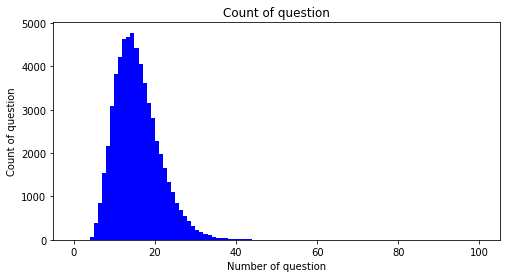

In [30]:
# Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à ÏÑ†Ïñ∏
# figsize: (Í∞ÄÎ°ú, ÏÑ∏Î°ú) ÌòïÌÉúÏùò ÌäúÌîåÎ°ú ÏûÖÎ†•
plt.figure(figsize=(8, 4))
# histogram ÏÑ†Ïñ∏
# bins: ÌûàÏä§ÌÜ†Í∑∏Îû® Í∞íÎì§Ïóê ÎåÄÌïú Î≤ÑÏºì Î≤îÏúÑ, 
# range: xÏ∂ï Í∞íÏùò Î≤îÏúÑ
# facecolor: Í∑∏ÎûòÌîÑ ÏÉâÏÉÅ
# label: Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú ÎùºÎ≤®
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
# Í∑∏ÎûòÌîÑ Ï†úÎ™©
plt.title('Count of question')
# Í∑∏ÎûòÌîÑ x Ï∂ï ÎùºÎ≤®
plt.xlabel('Number of question')
# Í∑∏ÎûòÌîÑ y Ï∂ï ÎùºÎ≤®
plt.ylabel('Count of question')
plt.show()

In [31]:
# Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥
print(f"question Í∏∏Ïù¥ ÏµúÎåÄ:    {np.max(train_question_counts):4d}")
print(f"question Í∏∏Ïù¥ ÏµúÏÜå:    {np.min(train_question_counts):4d}")
print(f"question Í∏∏Ïù¥ ÌèâÍ∑†:    {np.mean(train_question_counts):7.2f}")
print(f"question Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®: {np.std(train_question_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# Î∞±Î∂ÑÏúÑÏàò(Percentile)Îäî ÌÅ¨Í∏∞Í∞Ä ÏûàÎäî Í∞íÎì§Î°ú Ïù¥Î§ÑÏßÑ ÏûêÎ£åÎ•º ÏàúÏÑúÎåÄÎ°ú ÎÇòÏó¥ÌñàÏùÑ Îïå Î∞±Î∂ÑÏú®Î°ú ÎÇòÌÉÄÎÇ∏ ÌäπÏ†ï ÏúÑÏπòÏùò Í∞íÏùÑ Ïù¥Î•¥Îäî Ïö©Ïñ¥Ïù¥Îã§.
# ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÌÅ¨Í∏∞Í∞Ä ÏûëÏùÄ Í≤ÉÎ∂ÄÌÑ∞ ÎÇòÏó¥ÌïòÏó¨ Í∞ÄÏû• ÏûëÏùÄ Í≤ÉÏùÑ 0, Í∞ÄÏû• ÌÅ∞ Í≤ÉÏùÑ 100ÏúºÎ°ú ÌïúÎã§.
# 100Í∞úÏùò Í∞íÏùÑ Í∞ÄÏßÑ Ïñ¥Îñ§ ÏûêÎ£åÏùò 20 Î∞±Î∂ÑÏúÑÏàòÎäî Í∑∏ ÏûêÎ£åÏùò Í∞íÎì§ Ï§ë 20Î≤àÏß∏Î°ú ÏûëÏùÄ Í∞íÏùÑ ÎúªÌïúÎã§. 50 Î∞±Î∂ÑÏúÑÏàòÎäî Ï§ëÏïôÍ∞íÍ≥º Í∞ôÎã§.
percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100Î∂ÑÏúÑ:  {percentile25:7.2f}")
print(f"question 50/100Î∂ÑÏúÑ:  {percentile50:7.2f}")
print(f"question 75/100Î∂ÑÏúÑ:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100Î∂ÑÏúÑ: {percentileMAX:7.2f}")

question Í∏∏Ïù¥ ÏµúÎåÄ:      58
question Í∏∏Ïù¥ ÏµúÏÜå:       3
question Í∏∏Ïù¥ ÌèâÍ∑†:      15.25
question Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®:    5.50
question 25/100Î∂ÑÏúÑ:    11.00
question 50/100Î∂ÑÏúÑ:    14.00
question 75/100Î∂ÑÏúÑ:    18.00
question IQR:           7.00
question MAX/100Î∂ÑÏúÑ:   28.50


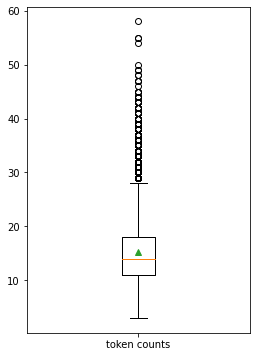

In [32]:
plt.figure(figsize=(4, 6))
# Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
# Ï≤´Î≤àÏß∏ ÌååÎùºÎ©îÌÑ∞: Ïó¨Îü¨ Î∂ÑÌè¨Ïóê ÎåÄÌïú Îç∞Ïù¥ÌÑ∞ Î¶¨Ïä§Ìä∏Î•º
# labels: ÏûÖÎ†•Ìïú Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÎùºÎ≤®
# showmeans: ÌèâÍ∑†Í∞íÏùÑ ÌëúÌòÑ
# Ï∞∏Í≥†: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

## (6) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Context
- ÏúÑÏôÄ ÎèôÏùºÌïú Î∞©Î≤ïÏúºÎ°ú context Ìï≠Î™©Ïóê ÎåÄÌï¥ÏÑúÎèÑ Î∂ÑÏÑù

In [33]:
# token count
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

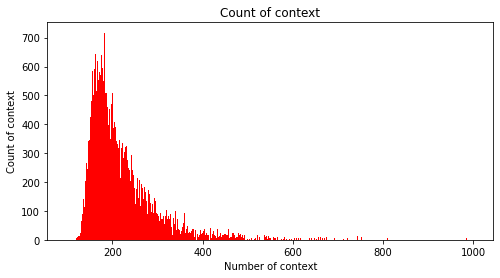

In [34]:
# Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à ÏÑ†Ïñ∏
# figsize: (Í∞ÄÎ°ú, ÏÑ∏Î°ú) ÌòïÌÉúÏùò ÌäúÌîåÎ°ú ÏûÖÎ†•
plt.figure(figsize=(8, 4))
# histogram ÏÑ†Ïñ∏
# bins: ÌûàÏä§ÌÜ†Í∑∏Îû® Í∞íÎì§Ïóê ÎåÄÌïú Î≤ÑÏºì Î≤îÏúÑ, 
# range: xÏ∂ï Í∞íÏùò Î≤îÏúÑ
# facecolor: Í∑∏ÎûòÌîÑ ÏÉâÏÉÅ
# label: Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú ÎùºÎ≤®
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
# Í∑∏ÎûòÌîÑ Ï†úÎ™©
plt.title('Count of context')
# Í∑∏ÎûòÌîÑ x Ï∂ï ÎùºÎ≤®
plt.xlabel('Number of context')
# Í∑∏ÎûòÌîÑ y Ï∂ï ÎùºÎ≤®
plt.ylabel('Count of context')
plt.show()

In [35]:
# Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥
print(f"context Í∏∏Ïù¥ ÏµúÎåÄ:    {np.max(train_context_counts):4d}")
print(f"context Í∏∏Ïù¥ ÏµúÏÜå:    {np.min(train_context_counts):4d}")
print(f"context Í∏∏Ïù¥ ÌèâÍ∑†:    {np.mean(train_context_counts):7.2f}")
print(f"context Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®: {np.std(train_context_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# Î∞±Î∂ÑÏúÑÏàò(Percentile)Îäî ÌÅ¨Í∏∞Í∞Ä ÏûàÎäî Í∞íÎì§Î°ú Ïù¥Î§ÑÏßÑ ÏûêÎ£åÎ•º ÏàúÏÑúÎåÄÎ°ú ÎÇòÏó¥ÌñàÏùÑ Îïå Î∞±Î∂ÑÏú®Î°ú ÎÇòÌÉÄÎÇ∏ ÌäπÏ†ï ÏúÑÏπòÏùò Í∞íÏùÑ Ïù¥Î•¥Îäî Ïö©Ïñ¥Ïù¥Îã§.
# ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÌÅ¨Í∏∞Í∞Ä ÏûëÏùÄ Í≤ÉÎ∂ÄÌÑ∞ ÎÇòÏó¥ÌïòÏó¨ Í∞ÄÏû• ÏûëÏùÄ Í≤ÉÏùÑ 0, Í∞ÄÏû• ÌÅ∞ Í≤ÉÏùÑ 100ÏúºÎ°ú ÌïúÎã§.
# 100Í∞úÏùò Í∞íÏùÑ Í∞ÄÏßÑ Ïñ¥Îñ§ ÏûêÎ£åÏùò 20 Î∞±Î∂ÑÏúÑÏàòÎäî Í∑∏ ÏûêÎ£åÏùò Í∞íÎì§ Ï§ë 20Î≤àÏß∏Î°ú ÏûëÏùÄ Í∞íÏùÑ ÎúªÌïúÎã§. 50 Î∞±Î∂ÑÏúÑÏàòÎäî Ï§ëÏïôÍ∞íÍ≥º Í∞ôÎã§.
percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100Î∂ÑÏúÑ:  {percentile25:7.2f}")
print(f"context 50/100Î∂ÑÏúÑ:  {percentile50:7.2f}")
print(f"context 75/100Î∂ÑÏúÑ:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100Î∂ÑÏúÑ: {percentileMAX:7.2f}")

context Í∏∏Ïù¥ ÏµúÎåÄ:    4816
context Í∏∏Ïù¥ ÏµúÏÜå:     108
context Í∏∏Ïù¥ ÌèâÍ∑†:     222.84
context Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®:   97.68
context 25/100Î∂ÑÏúÑ:   169.00
context 50/100Î∂ÑÏúÑ:   199.00
context 75/100Î∂ÑÏúÑ:   248.00
context IQR:          79.00
context MAX/100Î∂ÑÏúÑ:  366.50


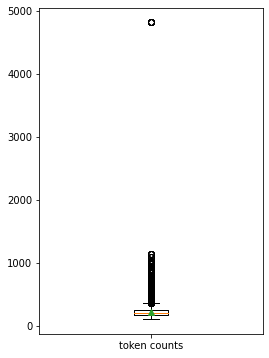

In [36]:
plt.figure(figsize=(4, 6))
# Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
# Ï≤´Î≤àÏß∏ ÌååÎùºÎ©îÌÑ∞: Ïó¨Îü¨ Î∂ÑÌè¨Ïóê ÎåÄÌïú Îç∞Ïù¥ÌÑ∞ Î¶¨Ïä§Ìä∏Î•º
# labels: ÏûÖÎ†•Ìïú Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÎùºÎ≤®
# showmeans: ÌèâÍ∑†Í∞íÏùÑ ÌëúÌòÑ
# Ï∞∏Í≥†: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

## (7) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Answer

In [37]:
# token count
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

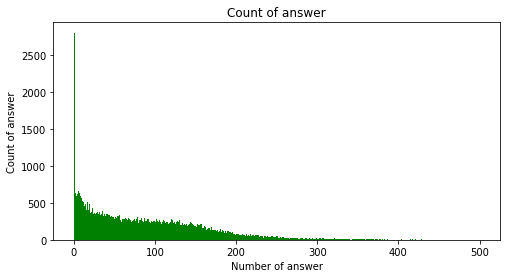

In [38]:
# Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à ÏÑ†Ïñ∏
# figsize: (Í∞ÄÎ°ú, ÏÑ∏Î°ú) ÌòïÌÉúÏùò ÌäúÌîåÎ°ú ÏûÖÎ†•
plt.figure(figsize=(8, 4))
# histogram ÏÑ†Ïñ∏
# bins: ÌûàÏä§ÌÜ†Í∑∏Îû® Í∞íÎì§Ïóê ÎåÄÌïú Î≤ÑÏºì Î≤îÏúÑ, 
# range: xÏ∂ï Í∞íÏùò Î≤îÏúÑ
# facecolor: Í∑∏ÎûòÌîÑ ÏÉâÏÉÅ
# label: Í∑∏ÎûòÌîÑÏóê ÎåÄÌïú ÎùºÎ≤®
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
# Í∑∏ÎûòÌîÑ Ï†úÎ™©
plt.title('Count of answer')
# Í∑∏ÎûòÌîÑ x Ï∂ï ÎùºÎ≤®
plt.xlabel('Number of answer')
# Í∑∏ÎûòÌîÑ y Ï∂ï ÎùºÎ≤®
plt.ylabel('Count of answer')
plt.show()

In [39]:
# Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥
print(f"answer ÏúÑÏπò ÏµúÎåÄ:    {np.max(train_answer_starts):4d}")
print(f"answer ÏúÑÏπò ÏµúÏÜå:    {np.min(train_answer_starts):4d}")
print(f"answer ÏúÑÏπò ÌèâÍ∑†:    {np.mean(train_answer_starts):7.2f}")
print(f"answer ÏúÑÏπò ÌëúÏ§ÄÌé∏Ï∞®: {np.std(train_answer_starts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# Î∞±Î∂ÑÏúÑÏàò(Percentile)Îäî ÌÅ¨Í∏∞Í∞Ä ÏûàÎäî Í∞íÎì§Î°ú Ïù¥Î§ÑÏßÑ ÏûêÎ£åÎ•º ÏàúÏÑúÎåÄÎ°ú ÎÇòÏó¥ÌñàÏùÑ Îïå Î∞±Î∂ÑÏú®Î°ú ÎÇòÌÉÄÎÇ∏ ÌäπÏ†ï ÏúÑÏπòÏùò Í∞íÏùÑ Ïù¥Î•¥Îäî Ïö©Ïñ¥Ïù¥Îã§.
# ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÌÅ¨Í∏∞Í∞Ä ÏûëÏùÄ Í≤ÉÎ∂ÄÌÑ∞ ÎÇòÏó¥ÌïòÏó¨ Í∞ÄÏû• ÏûëÏùÄ Í≤ÉÏùÑ 0, Í∞ÄÏû• ÌÅ∞ Í≤ÉÏùÑ 100ÏúºÎ°ú ÌïúÎã§.
# 100Í∞úÏùò Í∞íÏùÑ Í∞ÄÏßÑ Ïñ¥Îñ§ ÏûêÎ£åÏùò 20 Î∞±Î∂ÑÏúÑÏàòÎäî Í∑∏ ÏûêÎ£åÏùò Í∞íÎì§ Ï§ë 20Î≤àÏß∏Î°ú ÏûëÏùÄ Í∞íÏùÑ ÎúªÌïúÎã§. 50 Î∞±Î∂ÑÏúÑÏàòÎäî Ï§ëÏïôÍ∞íÍ≥º Í∞ôÎã§.
percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100Î∂ÑÏúÑ:  {percentile25:7.2f}")
print(f"answer 50/100Î∂ÑÏúÑ:  {percentile50:7.2f}")
print(f"answer 75/100Î∂ÑÏúÑ:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100Î∂ÑÏúÑ: {percentileMAX:7.2f}")

answer ÏúÑÏπò ÏµúÎåÄ:    1124
answer ÏúÑÏπò ÏµúÏÜå:       0
answer ÏúÑÏπò ÌèâÍ∑†:      89.01
answer ÏúÑÏπò ÌëúÏ§ÄÌé∏Ï∞®:   78.21
answer 25/100Î∂ÑÏúÑ:    25.00
answer 50/100Î∂ÑÏúÑ:    74.00
answer 75/100Î∂ÑÏúÑ:   134.00
answer IQR:         109.00
answer MAX/100Î∂ÑÏúÑ:  297.50


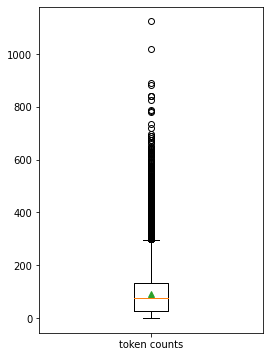

In [40]:
plt.figure(figsize=(4, 6))
# Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
# Ï≤´Î≤àÏß∏ ÌååÎùºÎ©îÌÑ∞: Ïó¨Îü¨ Î∂ÑÌè¨Ïóê ÎåÄÌïú Îç∞Ïù¥ÌÑ∞ Î¶¨Ïä§Ìä∏Î•º
# labels: ÏûÖÎ†•Ìïú Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÎùºÎ≤®
# showmeans: ÌèâÍ∑†Í∞íÏùÑ ÌëúÌòÑ
# Ï∞∏Í≥†: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

## (8) Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù : Word Cloud
- ÏõåÎìú ÌÅ¥ÎùºÏö∞Îìú(Word Cloud) : ÏûêÎ£åÏùò ÎπàÎèÑÏàòÎ•º ÏãúÍ∞ÅÌôîÌï¥ÏÑú ÎÇòÌÉÄÎÇ¥Îäî Î∞©Î≤ï
- Î¨∏ÏÑúÏùò ÌïµÏã¨ Îã®Ïñ¥Î•º ÌïúÎààÏóê ÌååÏïÖÌï† Ïàò ÏûàÍ≥†, ÎπÖÎç∞Ïù¥ÌÑ∞Î•º Î∂ÑÏÑùÌï† Îïå Îç∞Ïù¥ÌÑ∞Ïùò ÌäπÏßïÏùÑ ÎèÑÏ∂úÌïòÍ∏∞ ÏúÑÌï¥ÏÑú ÌôúÏö©Îê®
- ÎπàÎèÑÏàòÍ∞Ä ÎÜíÏùÄ Îã®Ïñ¥ÏùºÏàòÎ°ù Í∏ÄÏî® ÌÅ¨Í∏∞Í∞Ä ÌÅ∞ ÌäπÏßïÏù¥ ÏûàÏùå

In [41]:
# train documents
documents = []

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú title, context, question Î¨∏Ïû•ÏùÑ Î™®Îëê Ï∂îÏ∂úÌï©ÎãàÎã§. 
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]   # Í∑∏Ï§ë Îß® Ïïû 10Í∞úÎßå ÌôïÏù∏Ìï¥ Î¥ÖÎãàÎã§.

  0%|          | 0/1420 [00:00<?, ?it/s]

['ÌååÏö∞Ïä§Ìä∏_ÏÑúÍ≥°',
 '1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ Ï≤òÏùå ÏùΩÍ≥† Í∑∏ ÎÇ¥Ïö©Ïóê ÎßàÏùåÏù¥ ÎÅåÎ†§ Ïù¥Î•º ÏÜåÏû¨Î°ú Ìï¥ÏÑú ÌïòÎÇòÏùò ÍµêÌñ•Í≥°ÏùÑ Ïì∞Î†§Îäî ÎúªÏùÑ Í∞ñÎäîÎã§. Ïù¥ ÏãúÍ∏∞ Î∞îÍ∑∏ÎÑàÎäî 1838ÎÖÑÏóê Îπõ ÎèÖÏ¥âÏúºÎ°ú ÏÇ∞Ï†ÑÏàòÏ†ÑÏùÑ Îã§ Í±≤ÏùÄ ÏÉÅÌô©Ïù¥Îùº Ï¢åÏ†àÍ≥º Ïã§ÎßùÏóê Í∞ÄÎìùÌñàÏúºÎ©∞ Î©îÌîºÏä§ÌÜ†Ìé†Î†àÏä§Î•º ÎßåÎÇòÎäî ÌååÏö∞Ïä§Ìä∏Ïùò Ïã¨Í≤ΩÏóê Í≥µÍ∞êÌñàÎã§Í≥† ÌïúÎã§. ÎòêÌïú ÌååÎ¶¨ÏóêÏÑú ÏïÑÎ∏åÎÑ§ÌÅ¨Ïùò ÏßÄÌúòÎ°ú ÌååÎ¶¨ ÏùåÏïÖÏõê Í¥ÄÌòÑÏïÖÎã®Ïù¥ Ïó∞Ï£ºÌïòÎäî Î≤†ÌÜ†Î≤§Ïùò ÍµêÌñ•Í≥° 9Î≤àÏùÑ Îì£Í≥† ÍπäÏùÄ Í∞êÎ™ÖÏùÑ Î∞õÏïòÎäîÎç∞, Ïù¥Í≤ÉÏù¥ Ïù¥Îì¨Ìï¥ 1ÏõîÏóê ÌååÏö∞Ïä§Ìä∏Ïùò ÏÑúÍ≥°ÏúºÎ°ú Ïì∞Ïó¨ÏßÑ Ïù¥ ÏûëÌíàÏóê Ï°∞Í∏àÏù¥ÎùºÎèÑ ÏòÅÌñ•ÏùÑ ÎÅºÏ≥§ÏúºÎ¶¨ÎùºÎäî Í≤ÉÏùÄ ÏùòÏã¨Ìï† Ïó¨ÏßÄÍ∞Ä ÏóÜÎã§. Ïó¨Í∏∞Ïùò ÎùºÎã®Ï°∞ Ï°∞ÏÑ±Ïùò Í≤ΩÏö∞ÏóêÎèÑ Í∑∏Ïùò Ï†ÑÍ∏∞Ïóê Ï†ÅÌòÄ ÏûàÎäî Í≤ÉÏ≤òÎüº Îã®ÏàúÌïú Ï†ïÏã†Ï†Å ÌîºÎ°úÎÇò Ïã§ÏùòÍ∞Ä Î∞òÏòÅÎêú Í≤ÉÏù¥ ÏïÑÎãàÎùº Î≤†ÌÜ†Î≤§Ïùò Ìï©Ï∞ΩÍµêÌñ•Í≥° Ï°∞ÏÑ±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÄ Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. Í∑∏Î†áÍ≤å ÍµêÌñ•Í≥° ÏûëÍ≥°ÏùÑ 1839ÎÖÑÎ∂ÄÌÑ

In [42]:
# documentsÎ•º Ï†ÑÎ∂Ä Ïù¥Ïñ¥ ÌïòÎÇòÏùò Î¨∏Ïû•ÏúºÎ°ú ÎßåÎì§Î©¥ Ïù¥Î†áÍ≤å Î≥¥ÏûÖÎãàÎã§. 
" ".join(documents[:10])

'ÌååÏö∞Ïä§Ìä∏_ÏÑúÍ≥° 1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ Ï≤òÏùå ÏùΩÍ≥† Í∑∏ ÎÇ¥Ïö©Ïóê ÎßàÏùåÏù¥ ÎÅåÎ†§ Ïù¥Î•º ÏÜåÏû¨Î°ú Ìï¥ÏÑú ÌïòÎÇòÏùò ÍµêÌñ•Í≥°ÏùÑ Ïì∞Î†§Îäî ÎúªÏùÑ Í∞ñÎäîÎã§. Ïù¥ ÏãúÍ∏∞ Î∞îÍ∑∏ÎÑàÎäî 1838ÎÖÑÏóê Îπõ ÎèÖÏ¥âÏúºÎ°ú ÏÇ∞Ï†ÑÏàòÏ†ÑÏùÑ Îã§ Í±≤ÏùÄ ÏÉÅÌô©Ïù¥Îùº Ï¢åÏ†àÍ≥º Ïã§ÎßùÏóê Í∞ÄÎìùÌñàÏúºÎ©∞ Î©îÌîºÏä§ÌÜ†Ìé†Î†àÏä§Î•º ÎßåÎÇòÎäî ÌååÏö∞Ïä§Ìä∏Ïùò Ïã¨Í≤ΩÏóê Í≥µÍ∞êÌñàÎã§Í≥† ÌïúÎã§. ÎòêÌïú ÌååÎ¶¨ÏóêÏÑú ÏïÑÎ∏åÎÑ§ÌÅ¨Ïùò ÏßÄÌúòÎ°ú ÌååÎ¶¨ ÏùåÏïÖÏõê Í¥ÄÌòÑÏïÖÎã®Ïù¥ Ïó∞Ï£ºÌïòÎäî Î≤†ÌÜ†Î≤§Ïùò ÍµêÌñ•Í≥° 9Î≤àÏùÑ Îì£Í≥† ÍπäÏùÄ Í∞êÎ™ÖÏùÑ Î∞õÏïòÎäîÎç∞, Ïù¥Í≤ÉÏù¥ Ïù¥Îì¨Ìï¥ 1ÏõîÏóê ÌååÏö∞Ïä§Ìä∏Ïùò ÏÑúÍ≥°ÏúºÎ°ú Ïì∞Ïó¨ÏßÑ Ïù¥ ÏûëÌíàÏóê Ï°∞Í∏àÏù¥ÎùºÎèÑ ÏòÅÌñ•ÏùÑ ÎÅºÏ≥§ÏúºÎ¶¨ÎùºÎäî Í≤ÉÏùÄ ÏùòÏã¨Ìï† Ïó¨ÏßÄÍ∞Ä ÏóÜÎã§. Ïó¨Í∏∞Ïùò ÎùºÎã®Ï°∞ Ï°∞ÏÑ±Ïùò Í≤ΩÏö∞ÏóêÎèÑ Í∑∏Ïùò Ï†ÑÍ∏∞Ïóê Ï†ÅÌòÄ ÏûàÎäî Í≤ÉÏ≤òÎüº Îã®ÏàúÌïú Ï†ïÏã†Ï†Å ÌîºÎ°úÎÇò Ïã§ÏùòÍ∞Ä Î∞òÏòÅÎêú Í≤ÉÏù¥ ÏïÑÎãàÎùº Î≤†ÌÜ†Î≤§Ïùò Ìï©Ï∞ΩÍµêÌñ•Í≥° Ï°∞ÏÑ±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÄ Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. Í∑∏Î†áÍ≤å ÍµêÌñ•Í≥° ÏûëÍ≥°ÏùÑ 1839ÎÖÑÎ∂ÄÌÑ∞ 40Î

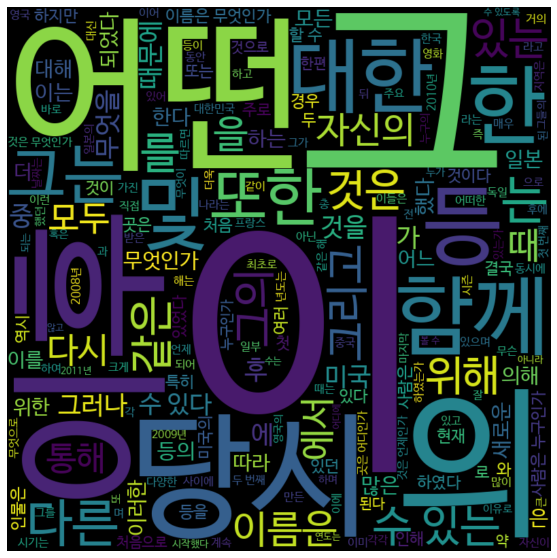

In [43]:
# WordCloudÎ°ú " ".join(documents)Î•º Ï≤òÎ¶¨Ìï¥ Î¥ÖÎãàÎã§. 
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))
# image Ï∂úÎ†•, interpolation Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôî ÏòµÏÖò
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import nltk

##########Îç∞Ïù¥ÌÑ∞ Î°úÎìú
x_data = documents



#ÌÖçÏä§Ìä∏ Ï†ïÏ†ú (Î∂àÏö©Ïñ¥ Ï†úÍ±∞)
nltk.download('punkt')
stopwords = ['Ïù¥', 'Ïûà', 'Ìïò', 'Í≤É', 'Îì§', 'Í∑∏', 'Îêò', 'Ïàò', 'Ïù¥', 'Î≥¥', 'Ïïä', 'ÏóÜ', 'ÎÇò', 'ÏÇ¨Îûå', 'Ï£º', 'ÏïÑÎãà', 'Îì±', 'Í∞ô', 'Ïö∞Î¶¨', 'Îïå', 'ÎÖÑ', 'Í∞Ä', 'Ìïú', 'ÏßÄ', 'ÎåÄÌïò', 'Ïò§', 'Îßê', 'Ïùº', 'Í∑∏Î†á', 'ÏúÑÌïò']
for i, document in enumerate(x_data):
    clean_words = [] 
    for word in nltk.tokenize.word_tokenize(document): 
        if word not in stopwords: #Î∂àÏö©Ïñ¥ Ï†úÍ±∞
            clean_words.append(word)
    print(clean_words)     
    x_data[i] = ' '.join(clean_words)        
print(x_data) #['Ïä§ÌÜ†Î¶¨ ÏßÑÏßú ÎÖ∏Ïûº' 'Ïã¨Ïò§ÌïòÎã§ Îò• Îî±Ïù¥Îã§' 'Ïì∞Î†àÍ∏∞ Í∞ôÎã§ ÏòÅÌôî ÏãúÍ∞Ñ ÏïÑÍπùÎã§' 'Ï†êÎèÑ ÏïÑÍπùÎã§ Ïì∞Î†àÍ∏∞ ÏòÅÌôî' 'ÎìúÎüΩÎã§ Í∏∞Î∂Ñ' 'Ïù¥Í±¥ Î™ÖÏûë ÏûÑ' 'Ïù¥Î†áÎã§ ÎäêÎÇå ÏòÅÌôî Ï¢ãÎã§' 'Ï£ΩÎã§ Î≥¥Îã§ ÏïºÌïòÎã§ ÏòÅÌôî' 'ÎªîÌïòÎã§ Î°úÏΩî ÏïÑÎãàÎã§ ÎåÄÏÇ¨ ÏïÑÏ£º Ï¢ãÎã§' 'Î≥¥Îã§ ÌõÑÌöå ÌïòÎã§ Í∞ôÎã§ Í∞êÎèô']

##  (9) Îç∞Ïù¥ÌÑ∞ Î°úÎìú
- ÏßÄÍ∏àÍπåÏßÄ ÎßåÎì† Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î©îÎ™®Î¶¨Ïóê Î°úÎìú

In [44]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [45]:
class Config(dict):
    """
    jsonÏùÑ config ÌòïÌÉúÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [46]:
# ÏÉùÏÑ±Ìïú Îç∞Ïù¥ÌÑ∞ÏÖã ÌååÏùºÏùÑ Î©îÎ™®Î¶¨Ïóê Î°úÎî©ÌïòÎäî Ìï®Ïàò
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # ÏµúÎåÄ Í∏∏Ïù¥ÎÇ¥Ïóê tokenÏù¥ Îì§Ïñ¥Í∞ÄÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ Ï≤òÎ¶¨ÌïòÏßÄ ÏïäÏùå
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [47]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

- ÎßåÎì† Îç∞Ïù¥ÌÑ∞ÏÖã ÌôïÏù∏

In [48]:
# QuestionÍ≥º ContextÍ∞Ä Ìè¨Ìï®Îêú ÏûÖÎ†•Îç∞Ïù¥ÌÑ∞ 1Î≤àÏß∏
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [49]:
# QuestionÏùÑ 0ÏúºÎ°ú, ContextÎ•º 1Î°ú Íµ¨Î∂ÑÌï¥ Ï§Ä Segment Îç∞Ïù¥ÌÑ∞ 1Î≤àÏß∏
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [50]:
# AnswerÏúÑÏπòÏùò ÏãúÏûëÏ†êÍ≥º ÎÅùÏ†ê ÎùºÎ≤® 1Î≤àÏß∏
train_labels[0][0], train_labels[1][0]

(37, 37)

# STEP 3. LSTM Model

In [89]:
def build_model_lstm(n_vocab, n_seq, d_model):
    tokens = tf.keras.layers.Input((None,), name='tokens')
    segments = tf.keras.layers.Input((None,), name='segments')

    hidden = tf.keras.layers.Embedding(n_vocab, d_model)(tokens) + tf.keras.layers.Embedding(2, d_model)(segments) # (bs, n_seq, d_model)

    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.Dense(2)(hidden) # (bs, n_seq, 2)
    start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)
    start_logits = tf.squeeze(start_logits, axis=-1)  # (bs, n_seq)
    start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)
    end_logits = tf.squeeze(end_logits, axis=-1)  # (bs, n_seq)
    end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

    model = tf.keras.Model(inputs=(tokens, segments), outputs=(start_outputs, end_outputs))
    return model

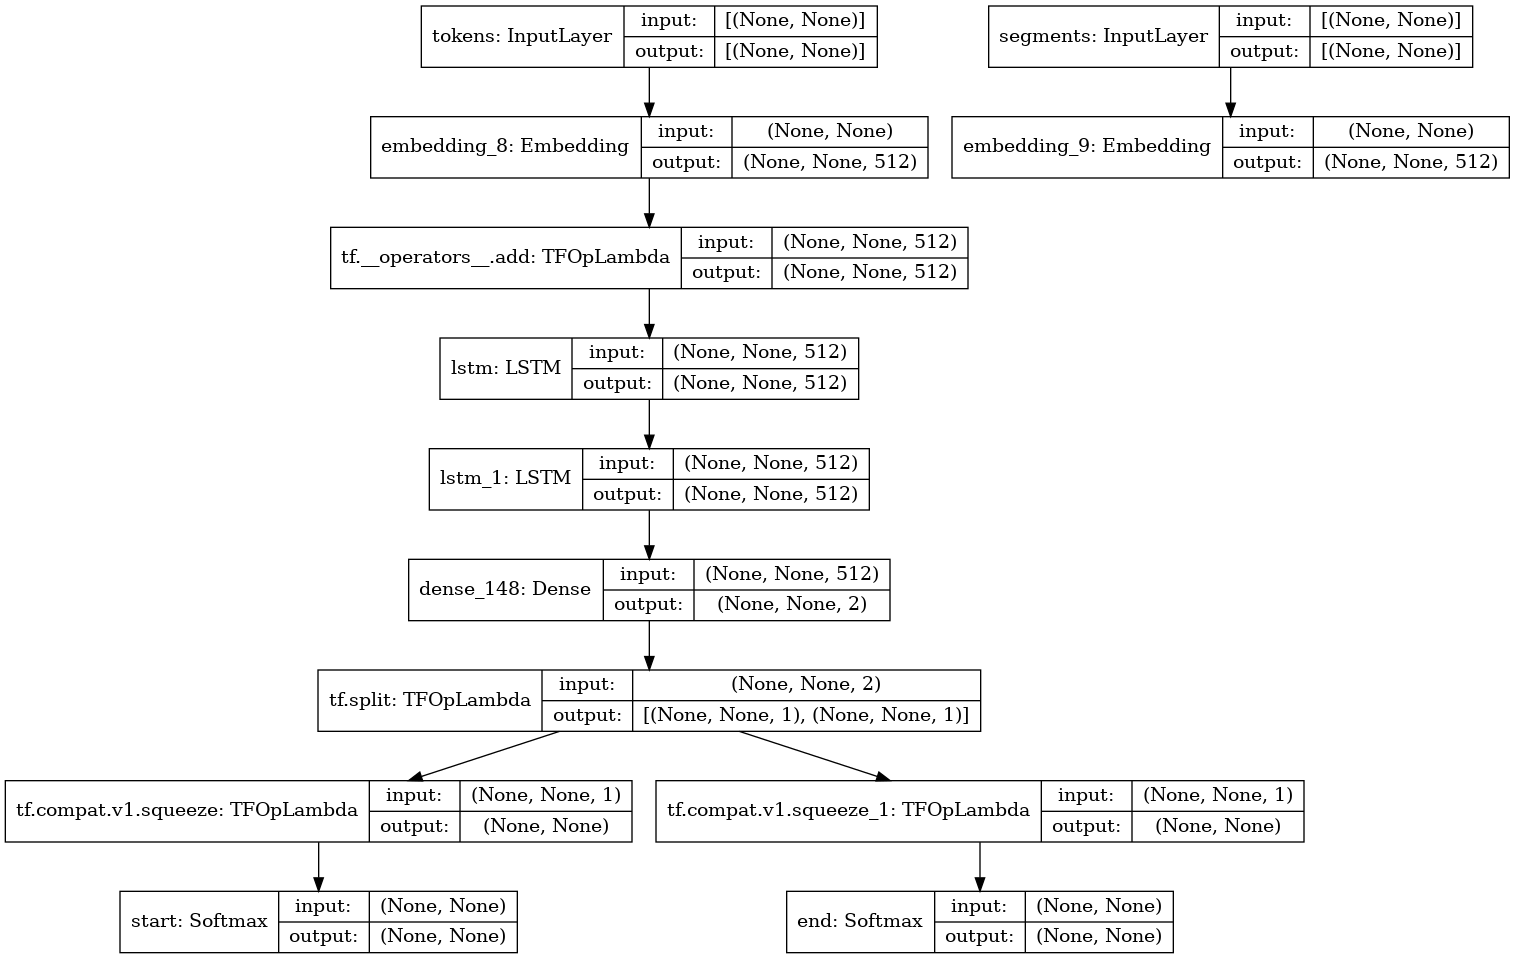

In [90]:
model = build_model_lstm(n_vocab=len(vocab), n_seq=512, d_model=512)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [91]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_start_accuracy', patience=3)
# save weights
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(data_dir, "korquad_lstm.hdf5"), monitor='val_start_accuracy', verbose=1, save_best_only=True, mode='max', save_freq='epoch', save_weights_only=True)

history = model.fit(train_inputs, train_labels, epochs=10, batch_size=128, validation_data=(dev_inputs, dev_labels), callbacks=[early_stopping, save_weights])

Epoch 1/10
469/469 [==============================] - 207s 430ms/step - loss: 8.7478 - start_loss: 4.2017 - end_loss: 4.5461 - start_accuracy: 0.0787 - end_accuracy: 0.0638 - val_loss: 8.1178 - val_start_loss: 3.8427 - val_end_loss: 4.2751 - val_start_accuracy: 0.1015 - val_end_accuracy: 0.0823

Epoch 00001: val_start_accuracy improved from -inf to 0.10147, saving model to /aiffel/aiffel/bert_qna/data/korquad_lstm.hdf5
Epoch 2/10
469/469 [==============================] - 203s 433ms/step - loss: 7.1840 - start_loss: 3.4305 - end_loss: 3.7535 - start_accuracy: 0.1293 - end_accuracy: 0.1217 - val_loss: 8.2089 - val_start_loss: 3.8999 - val_end_loss: 4.3090 - val_start_accuracy: 0.0985 - val_end_accuracy: 0.0823

Epoch 00002: val_start_accuracy did not improve from 0.10147
Epoch 3/10
469/469 [==============================] - 204s 434ms/step - loss: 6.6091 - start_loss: 3.1845 - end_loss: 3.4245 - start_accuracy: 0.1608 - end_accuracy: 0.1546 - val_loss: 8.4323 - val_start_loss: 4.0150 - 

In [ ]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['start_accuracy'], 'g-', label='start_accuracy')
plt.plot(history.history['val_start_accuracy'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['end_accuracy'], 'b-', label='end_accuracy')
plt.plot(history.history['val_end_accuracy'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

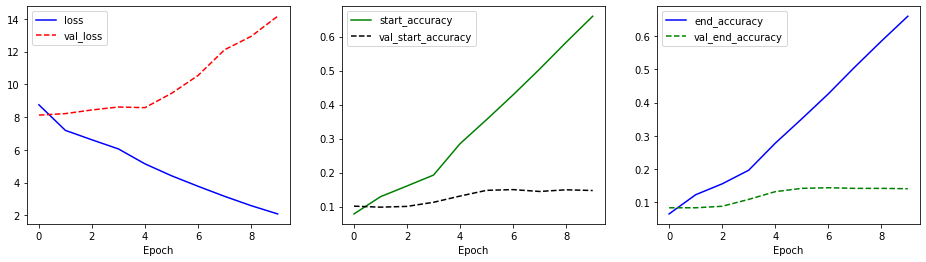

# STEP 4. BERT Model
## (1)  BERT Î†àÏù¥Ïñ¥ Íµ¨ÏÑ±

In [51]:
# Ïú†Ìã∏Î¶¨Ìã∞ Ìï®ÏàòÎì§

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation Ìï®Ïàò
    :param x: ÏûÖÎ†• Í∞í
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer ÏÉùÏÑ±
    :param stddev: ÏÉùÏÑ±Ìï† ÎûúÎç§ Î≥ÄÏàòÏùò ÌëúÏ§ÄÌé∏Ï∞®
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer ÏÉùÏÑ±
    """
    return tf.zeros_initializer


class Config(dict):
    """
    jsonÏùÑ config ÌòïÌÉúÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        fileÏóêÏÑú ConfigÎ•º ÏÉùÏÑ± Ìï®
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [52]:
# mode == "embedding" Ïùº Í≤ΩÏö∞ Token Embedding Layer Î°ú ÏÇ¨Ïö©ÎêòÎäî layer ÌÅ¥ÎûòÏä§ÏûÖÎãàÎã§. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight ÏÉùÏÑ±
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :param mode: Ïã§Ìñâ Î™®Îìú
        :return: embedding or linear Ïã§Ìñâ Í≤∞Í≥º
        """
        # modeÍ∞Ä embeddingÏùº Í≤ΩÏö∞ embedding lookup Ïã§Ìñâ
        if mode == "embedding":
            return self._embedding(inputs)
        # modeÍ∞Ä linearÏùº Í≤ΩÏö∞ linear Ïã§Ìñâ
        elif mode == "linear":
            return self._linear(inputs)
        # modeÍ∞Ä Í∏∞ÌÉÄÏùº Í≤ΩÏö∞ Ïò§Î•ò Î∞úÏÉù
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: ÏûÖÎ†•
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [53]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :return embed: positional embedding lookup Í≤∞Í≥º
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [54]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [55]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [56]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: inputs
        :return ff_val: feed forward Ïã§Ìñâ Í≤∞Í≥º
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [57]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer Ïã§Ìñâ
        :param enc_embed: enc_embed ÎòêÎäî Ïù¥Ï†Ñ EncoderLayerÏùò Ï∂úÎ†•
        :param self_mask: enc_tokensÏùò pad mask
        :return enc_out: EncoderLayer Ïã§Ìñâ Í≤∞Í≥º
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [58]:
# Î†àÏù¥Ïñ¥ Í≤∞Ìï©
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer Ïã§Ìñâ
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS Í≤∞Í≥º logits
        :return logits_lm: LM Í≤∞Í≥º logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: ÏûÖÎ†• tokens
        :param segments: ÏûÖÎ†• segments
        :return embed: embedding Í≤∞Í≥º
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

## (2)  BERT Î™®Îç∏ Íµ¨ÌòÑ
- BERT Î†àÏù¥Ïñ¥Ïóê Fully Connected layerÎ•º Î∂ôÏñ¥ KorQuADÏö©ÏúºÎ°ú finetuneÌïòÍ∏∞ ÏúÑÌïú Î™®Îç∏ ÌÅ¥ÎûòÏä§

In [59]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

- ConfigÏùÑ ÌÜµÌï¥ Ïã§Ï†úÎ°ú Ïö∞Î¶¨Í∞Ä ÏÇ¨Ïö©Ìï† Î™®Îç∏ ÏÇ¨Ïù¥Ï¶àÎ•º Ï°∞Ï†ï
- BERT ÎÖºÎ¨∏Ïóê Í≥µÍ∞úÎêú Ïã§Ï†ú ÏÇ¨Ïù¥Ï¶à
    - BERT-base(110M parameters) : 12-layer, 768-hidden, 12-heads
    - BERT-large (336M parameters) : 24-layer, 1024-hidden, 16-heads
- Í±∞ÎåÄÌïú Î™®Îç∏ÏùÑ ÏûëÏùÄ Ïã§ÏäµÌôòÍ≤ΩÏóêÏÑú Îã§Î£®Í∏∞Ïóê Î¨¥Î¶¨Í∞Ä ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê ÏÇ¨Ïù¥Ï¶à Ï°∞Ï†ï
    => Our Tiny Bert(29M parameters) : 6-layer, 512-hidden, 8-heads

In [65]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [66]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

- BERTÎäî pretrained Î™®Îç∏ÏùÑ ÌôúÏö©ÌïòÎäî Îç∞ ÏùòÏùòÍ∞Ä ÏûàÏùå
- 1Îã¨ Ï†ïÎèÑ ÌïôÏäµÏùÑ ÏãúÏºú ÏÑ±Îä•Ïù¥ ÎÇòÏò§Îäî Í±∞ÎåÄ Î™®Îç∏Ïù¥Í∏∞ ÎïåÎ¨∏Ïóê Ïã§ÏäµÏóêÏÑúÎäî pretrainingÏùÑ Ï†úÏô∏ÌïòÍ≥† ÏßÑÌñâÌïúÎã§.
- Ïù¥ÌõÑ pretrained modelÌôúÏö©Í≥º ÎπÑÍµêÌï¥Î≥∏Îã§.

In [67]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [68]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [69]:
model = BERT4KorQuAD(config)

loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(3):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 4.1733, 4.7013, acc: 0.0846, 0.0637
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9506, 5.9506, acc: 0.0600, 0.0005


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9506, 5.9506, acc: 0.0599, 0.0002
early stopping


In [75]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0

t_start_loss_list, t_end_loss_list, t_start_acc_list, t_end_acc_list = [], [], [], []
v_start_loss_list, v_end_loss_list, v_start_acc_list, v_end_acc_list = [], [], [], []

for epoch in range(5):
    # train dataset
    t_start_loss, t_end_loss, t_start_acc, t_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    
    # valid dataset
    v_start_loss, v_end_loss, v_start_acc, v_end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {v_start_loss:0.4f}, {v_end_loss:0.4f}, acc: {v_start_acc:0.4f}, {v_end_acc:0.4f}')
    
    t_start_loss_list.append(t_start_loss)
    t_end_loss_list.append(t_end_loss)
    t_start_acc_list.append(t_start_acc)
    t_end_acc_list.append(t_end_acc)
    
    v_start_loss_list.append(v_start_loss)
    v_end_loss_list.append(v_end_loss)
    v_start_acc_list.append(v_start_acc)
    v_end_acc_list.append(v_end_acc)
    
    acc = v_start_acc + v_end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.9506, 5.9506, acc: 0.0054, 0.0074
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9506, 5.9506, acc: 0.0235, 0.0090
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9506, 5.9506, acc: 0.0028, 0.0025


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.9506, 5.9506, acc: 0.0037, 0.0028
early stopping


In [ ]:
noPre = pd.DataFrame({'start_loss': start_loss_list,
                    'end_loss': end_loss_list,
                    'start_acc': start_acc_list,
                    'end_acc': end_acc_list})
noPre['loss'] = noPre['start_loss'] + noPre['end_loss']
noPre['acc'] = noPre['start_acc'] + noPre['end_acc']
noPre

# STEP 4. Pretrained model ÌôúÏö©
## (1) pretrained model Î°úÎî©ÌïòÍ∏∞

In [77]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model ÏùÑ Î°úÎìúÌïòÍ∏∞ ÏúÑÌï¥ Î®ºÏ†Ä Î™®Îç∏Ïù¥ ÏÉùÏÑ±ÎêòÏñ¥ ÏûàÏñ¥Ïïº ÌïúÎã§.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint ÌååÏùºÎ°úÎ∂ÄÌÑ∞ ÌïÑÏöîÌïú layerÎ•º Î∂àÎü¨Ïò®Îã§. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_147 (Dense)            multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


## (2) pretrained model finetune ÌïòÍ∏∞

In [78]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0

t_start_loss_list, t_end_loss_list, t_start_acc_list, t_end_acc_list = [], [], [], []
v_start_loss_list, v_end_loss_list, v_start_acc_list, v_end_acc_list = [], [], [], []

for epoch in range(5):
    # train dataset
    t_start_loss, t_end_loss, t_start_acc, t_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    
    # valid dataset
    v_start_loss, v_end_loss, v_start_acc, v_end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {v_start_loss:0.4f}, {v_end_loss:0.4f}, acc: {v_start_acc:0.4f}, {v_end_acc:0.4f}')
    
    t_start_loss_list.append(t_start_loss)
    t_end_loss_list.append(t_end_loss)
    t_start_acc_list.append(t_start_acc)
    t_end_acc_list.append(t_end_acc)
    
    v_start_loss_list.append(v_start_loss)
    v_end_loss_list.append(v_end_loss)
    v_start_acc_list.append(v_start_acc)
    v_end_acc_list.append(v_end_acc)
    
    acc = v_start_acc + v_end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.8992, 2.1982, acc: 0.5112, 0.4673
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.7358, 2.0193, acc: 0.5451, 0.4984
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8779, 2.1756, acc: 0.5277, 0.4761


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 2.0358, 2.3330, acc: 0.5397, 0.4838
early stopping


In [ ]:
Pre = pd.DataFrame({'t_start_loss': start_loss_list,
                    't_end_loss': end_loss_list,
                    't_start_acc': start_acc_list,
                    't_end_acc': end_acc_list})
Pre['loss'] = Pre['t_start_loss'] + Pre['t_end_loss']
Pre['acc'] = Pre['t_start_acc'] + Pre['t_end_acc']
Pre

## (3) Inference ÏàòÌñâÌïòÍ∏∞
- finetune ÌïôÏäµÏù¥ ÏôÑÎ£åÎêú modelÏùÑ ÌôúÏö©ÌïòÏó¨ Ïã§Ï†ú ÌÄ¥Ï¶à ÌíÄÏù¥ Í≤∞Í≥ºÎ•º ÌôïÏù∏ Ìï¥Î≥¥Í∏∞!

In [80]:
def do_predict(model, question, context):
    """
    ÏûÖÎ†•Ïóê ÎåÄÌïú ÎãµÎ≥Ä ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò
    :param model: model
    :param question: ÏûÖÎ†• Î¨∏ÏûêÏó¥
    :param context: ÏûÖÎ†• Î¨∏ÏûêÏó¥
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [81]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("ÏßàÎ¨∏ : ", question)
            print("ÏßÄÎ¨∏ : ", context)
            print("Ï†ïÎãµ : ", answer)
            print("ÏòàÏ∏° : ", answer_predict, "\n")
        if 100 < i:
            break

0
ÏßàÎ¨∏ :  ÏûÑÏ¢ÖÏÑùÏù¥ Ïó¨ÏùòÎèÑ ÎÜçÎØº Ìè≠Î†• ÏãúÏúÑÎ•º Ï£ºÎèÑÌïú ÌòêÏùòÎ°ú ÏßÄÎ™ÖÏàòÎ∞∞ Îêú ÎÇ†ÏùÄ?
ÏßÄÎ¨∏ :  1989ÎÖÑ 2Ïõî 15Ïùº Ïó¨ÏùòÎèÑ ÎÜçÎØº Ìè≠Î†• ÏãúÏúÑÎ•º Ï£ºÎèÑÌïú ÌòêÏùò(Ìè≠Î†•ÌñâÏúÑÎì±Ï≤òÎ≤åÏóêÍ¥ÄÌïúÎ≤ïÎ•†ÏúÑÎ∞ò)ÏúºÎ°ú ÏßÄÎ™ÖÏàòÎ∞∞ÎêòÏóàÎã§. 1989ÎÖÑ 3Ïõî 12Ïùº ÏÑúÏö∏ÏßÄÎ∞©Í≤ÄÏ∞∞Ï≤≠ Í≥µÏïàÎ∂ÄÎäî ÏûÑÏ¢ÖÏÑùÏùò ÏÇ¨Ï†ÑÍµ¨ÏÜçÏòÅÏû•ÏùÑ Î∞úÎ∂ÄÎ∞õÏïòÎã§. Í∞ôÏùÄ Ìï¥ 6Ïõî 30Ïùº ÌèâÏñëÏ∂ïÏ†ÑÏóê ÏûÑÏàòÍ≤ΩÏùÑ ÎåÄÌëúÎ°ú ÌååÍ≤¨ÌïòÏó¨ Íµ≠Í∞ÄÎ≥¥ÏïàÎ≤ïÏúÑÎ∞ò ÌòêÏùòÍ∞Ä Ï∂îÍ∞ÄÎêòÏóàÎã§. Í≤ΩÏ∞∞ÏùÄ 12Ïõî 18Ïùº~20Ïùº ÏÇ¨Ïù¥ ÏÑúÏö∏ Í≤ΩÌù¨ÎåÄÌïôÍµêÏóêÏÑú ÏûÑÏ¢ÖÏÑùÏù¥ ÏÑ±Î™Ö Î∞úÌëúÎ•º Ï∂îÏßÑÌïòÍ≥† ÏûàÎã§Îäî Ï≤©Î≥¥Î•º ÏûÖÏàòÌñàÍ≥†, 12Ïõî 18Ïùº Ïò§Ï†Ñ 7Ïãú 40Î∂Ñ Í≤Ω Í∞ÄÏä§Ï¥ùÍ≥º Ï†ÑÏûêÎ¥âÏúºÎ°ú Î¨¥Ïû•Ìïú ÌäπÍ≥µÏ°∞ Î∞è ÎåÄÍ≥µÍ≥º ÏßÅÏõê 12Î™Ö Îì± 22Î™ÖÏùò ÏÇ¨Î≥µ Í≤ΩÏ∞∞ÏùÑ ÏäπÏö©Ï∞® 8ÎåÄÏóê ÎÇòÎàÑÏñ¥ Í≤ΩÌù¨ÎåÄÌïôÍµêÏóê Ìà¨ÏûÖÌñàÎã§. 1989ÎÖÑ 12Ïõî 18Ïùº Ïò§Ï†Ñ 8Ïãú 15Î∂Ñ Í≤Ω ÏÑúÏö∏Ï≤≠ÎüâÎ¶¨Í≤ΩÏ∞∞ÏÑúÎäî Ìò∏ÏúÑ ÌïôÏÉù 5Î™ÖÍ≥º Ìï®Íªò Í≤ΩÌù¨ÎåÄÌïôÍµê ÌïôÏÉùÌöåÍ¥Ä Í±¥Î¨º Í≥ÑÎã®ÏùÑ ÎÇ¥Î†§Ïò§Îäî ÏûÑÏ¢ÖÏÑùÏùÑ Î

# STEP 5. ÌïôÏäµ Í≤ΩÍ≥º ÏãúÍ∞ÅÌôî ÎπÑÍµê Î∂ÑÏÑù
## (1) LSTM

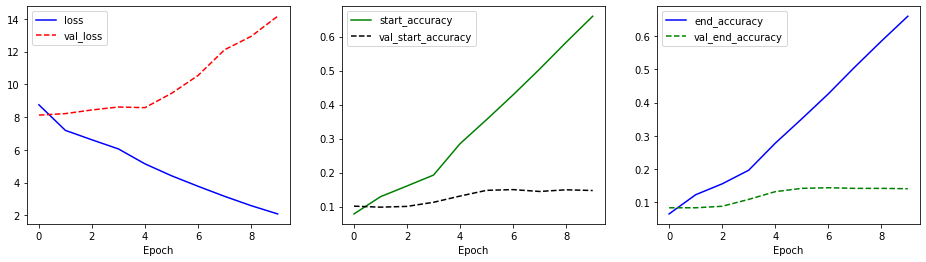


## (2) Pretrained model ÎØ∏ÌôúÏö©

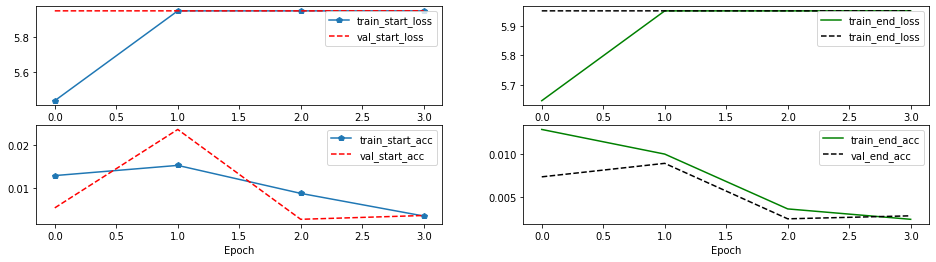

In [76]:
plt.figure(figsize=(16, 4))

plt.subplot(2, 2, 1)
plt.plot(t_start_loss_list, 'p-', label='train_start_loss')
plt.plot(v_start_loss_list, 'r--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t_end_loss_list, 'g-', label='train_end_loss')
plt.plot(v_end_loss_list, 'k--', label='train_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t_start_acc_list, 'p-', label='train_start_acc')
plt.plot(v_start_acc_list, 'r--', label='val_start_acc')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(t_end_acc_list, 'g-', label='train_end_acc')
plt.plot(v_end_acc_list, 'k--', label='val_end_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## (3) Pretrained model ÌôúÏö©

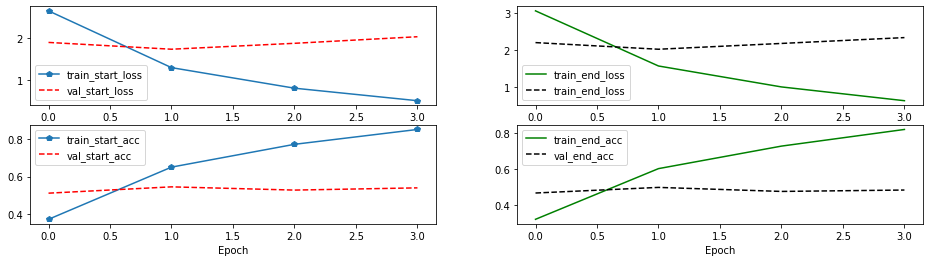

In [79]:
plt.figure(figsize=(16, 4))

plt.subplot(2, 2, 1)
plt.plot(t_start_loss_list, 'p-', label='train_start_loss')
plt.plot(v_start_loss_list, 'r--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t_end_loss_list, 'g-', label='train_end_loss')
plt.plot(v_end_loss_list, 'k--', label='train_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t_start_acc_list, 'p-', label='train_start_acc')
plt.plot(v_start_acc_list, 'r--', label='val_start_acc')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(t_end_acc_list, 'g-', label='train_end_acc')
plt.plot(v_end_acc_list, 'k--', label='val_end_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## (4) Í≤∞Í≥º Î∂ÑÏÑù
- Pretrained ModelÏùÑ ÏÇ¨Ïö©ÌïòÏòÄÏùÑ ÎïåÍ∞Ä ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏïòÏùÑ ÎïåÏóê ÎπÑÌï¥ loss Í∞Ä ÌòÑÏ†ÄÌûà Ï§ÑÏñ¥Îì†Îã§.
- ÎøêÎßå ÏïÑÎãàÎùº accuracyÎäî Pretrained ModelÎ•º ÏÇ¨Ïö©ÌïòÏòÄÏùÑ ÎïåÍ∞Ä ÏõîÎì±Ïù¥ ÎÜíÎã§.
- ÏúÑ Í∑∏ÎûòÌîÑÏùò train_accÎ•º ÌÜµÌï¥ÏÑú accuracyÍ∞Ä ÏïàÏ†ïÏ†ÅÏúºÎ°ú Ï¢ãÏïÑÏßÄÍ≥† ÏûàÎã§Îäî ÏÇ¨Ïã§ÏùÑ Î≥º Ïàò ÏûàÎã§.
- Ï¥ù 5EpcohÎ•º ÎèåÎ†∏Í≥† 4EpochÏúºÎ°ú early stopping ÎêòÏóàÎã§.


|Íµ¨Î∂Ñ|start_loss|end_loss|start_acc|end_loss|epoch|
|---|---|---|---|---|---|
|non pretrained|5.9506|5.9506|0.0037|0.0028|4(early stopping)|
|pretrained|2.0358|2.3330|0.5397|0.4838|4(early stopping)|

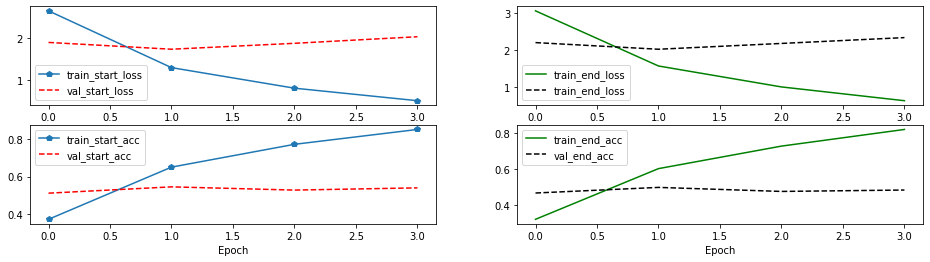

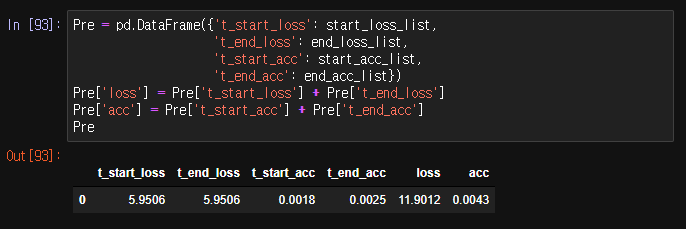

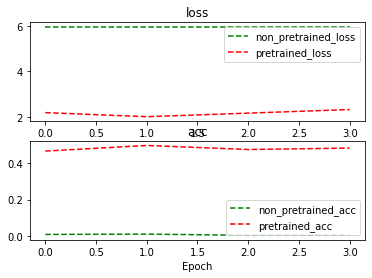

In [88]:
import matplotlib.pyplot as plt
 

non_pretrained_loss = [5.9506, 5.9506, 5.9506, 5.9506]
pretrained_loss = [2.1982, 2.0193, 2.1756, 2.3330]
non_pretrained_acc = [0.0074, 0.0090, 0.0025, 0.0028]
pretrained_acc = [0.4673, 0.4984, 0.4761, 0.4838]

 
#ÏÑ† Í∑∏ÎûòÌîÑÎ•º Í∑∏Î¶∞Îã§. xÏ∂ïÏóêÎäî yearsÍ∞í, yÏ∂ïÏóêÎäî gdpÍ∞íÏùÑ ÌëúÏãúÌïúÎã§.
plt.plot(non_pretrained_loss, pretrained_loss, color = 'green', marker = 'o', linestyle = 'solid')

plt.subplot(2, 1, 1)
plt.plot(non_pretrained_loss, 'g--', label='non_pretrained_loss')
plt.plot(pretrained_loss, 'r--', label='pretrained_loss')
plt.title('loss')
plt.xlabel('Epoch')
plt.legend()
 
plt.subplot(2, 1, 2)
plt.plot(non_pretrained_acc, 'g--', label='non_pretrained_acc')
plt.plot(pretrained_acc, 'r--', label='pretrained_acc')
plt.title('acc')
plt.xlabel('Epoch')
plt.legend()

- ÏõåÎìú ÌÅ¥ÎùºÏö∞Îìú Î∂ÑÏÑù
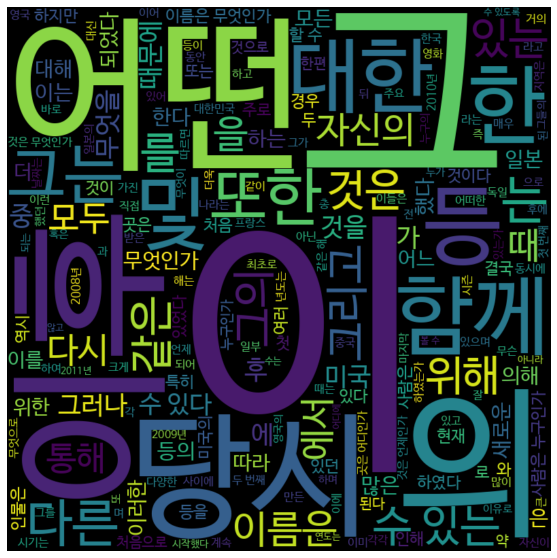
ÏõåÎìú ÌÅ¥ÎùºÏö∞ÎìúÎ•º Î≥¥ÏïòÏùÑ Îïå Ï£ºÎ°ú Ï°∞ÏÇ¨Í∞Ä ÌÅ∞ ÎπÑÏ§ëÏùÑ Ï∞®ÏßÄÌïúÎã§Îäî Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§.   
ÌÖçÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í≥ºÏó∞ Ï°∞ÏÇ¨Í∞Ä Ï§ëÏöîÌïú Ïó≠Ìï†ÏùºÍπå? ÎùºÍ≥† ÏÉùÍ∞ÅÏùÑ Ìï¥Î≥¥Î©¥ ÏùºÎ∞ò Î™ÖÏÇ¨ÎÇò ÎèôÏÇ¨Í∞Ä ÎçîÏö± Ï§ëÏöîÌïòÎã§Îäî Í≤ÉÏØ§ÏùÑ Ïïå Ïàò ÏûàÎã§.   
Ïù¥Î•º ÏúÑÌï¥ Î≥¥ÌÜµ ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨Î•º Ìï† Îïå Î∂àÏö©Ïñ¥ Ï≤òÎ¶¨Î•º Ìï¥Ï§ÄÎã§.   
Ïù¥Î≤àÏóêÎèÑ Î∂àÏö©Ïñ¥ Ï≤òÎ¶¨Î•º Ìï¥Ï£ºÍ≥† Ïã∂ÏóàÏßÄÎßå BERT ModelÏùÑ Îã§ ÎèåÎ¶¨Í∏∞ ÍπåÏßÄÎäî ÏÉÅÎãπ ÏãúÍ∞ÑÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏïÑ moelÏóêÎäî ÌôúÏö©ÌïòÏßÄ Î™ª ÌñàÎã§.   
Ïù¥Î∂ÄÎ∂ÑÏùÄ Îî∞Î°ú ÏßÑÌñâÌï¥Î≥¥Í≥† Ïã∂Îã§.   

# ü§îÌöåÍ≥†ü§î
### <Î£®Î∏åÎ¶≠ ÌèâÍ∞Ä ÏßÄÌëú>
|   ÌèâÍ∞ÄÎ¨∏Ìï≠    |ÏÉÅÏÑ∏Í∏∞Ï§Ä|
|---|---|
|1. BERT pretrained modelÏùÑ ÌôúÏö©Ìïú KorQuAD Î™®Îç∏Ïù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÌïôÏäµÏù¥ ÏßÑÌñâÎêòÏóàÎã§.|KorQuAD Î™®Îç∏Ïùò validation accuracyÍ∞Ä ÏïàÏ†ïÏ†ÅÏúºÎ°ú Ï¶ùÍ∞ÄÌïòÏòÄÎã§.|
|2. KorQuAD Inference Í≤∞Í≥ºÍ∞Ä ÏõêÎûòÏùò Ï†ïÎãµÍ≥º ÎπÑÍµêÌïòÏó¨ Ïú†ÏÇ¨ÌïòÍ≤å ÎÇòÏò§Îäî Í≤ÉÏùÑ ÌôïÏù∏ÌïòÏòÄÎã§.|ÌèâÍ∞ÄÏÖãÏóê ÎåÄÌï¥ Î™®Îç∏ Ï∂îÎ°† Í≤∞Í≥ºÏôÄ Ïã§Ï†ú Ï†ïÎãµÏùò Ïú†ÏÇ¨ÏÑ±Ïù¥ ÌôïÏù∏ÎêòÏóàÎã§.|
|3. pretrained model ÌôúÏö©Ïù¥ Ìö®Í≥ºÏ†ÅÏûÑÏùÑ Ïã§ÌóòÏùÑ ÌÜµÌï¥ ÌôïÏù∏ÌïòÏòÄÎã§.|pretrained modelÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏïòÏùÑ Îïå ÎåÄÎπÑ ÌïôÏäµÍ≤ΩÍ≥ºÏùò Ï∞®Ïù¥Î•º ÏãúÍ∞ÅÌôîÎ•º ÌÜµÌï¥ ÌôïÏù∏ÌïòÏòÄÎã§.|

### <Ïù¥Î≤à ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑú Ïñ¥Î†§Ïõ†Îçò Ï†ê>
1. ÏùºÎã® ÏßëÏ§ëÏù¥ ÎÑàÎ¨¥ ÏïàÎêêÎã§. Îî± Î©¥Ï†ë Ï§ÄÎπÑ Í∏∞Í∞ÑÏù¥Îûë Í≤πÏ≥ê Ìï†Í≤å ÎßéÏïòÎã§.   
2. Ïñ¥Î†µÎã§.. ÎÇú Î∂ÑÎ™Ö RoBERTa Î™®Îç∏ÎèÑ longformer Î™®Îç∏ÎèÑ Î≥¥ÏïòÎäîÎç∞ ÎÇ¥Ïö©Ïù¥ ÎÑàÎ¨¥ ÏÉàÎ°≠Îã§. „Öã„Öã„Öã„Öã„Öã„Öã Î™®Îç∏Ïóê ÎåÄÌïú Ïù¥Ìï¥ÎèÑÍ∞Ä ÏïÑÏßÅ Ï†úÎ°úÏù∏ Í≤É Í∞ôÎã§...   
3. Î™®Îç∏ÏùÑ ÌïôÏäµÌïòÎäîÎç∞ ÏãúÍ∞ÑÏù¥ ÎÑàÎ¨¥ Ïò§ÎûòÍ±∏Î†∏Îã§. Ïù¥Ï†Ñ ÎÖ∏ÎìúÎì§ÏùÄ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Îì§ÏùÑ Îã§ÏñëÌïòÍ≤å ÏàòÏ†ï Î≥ÄÍ≤ΩÌïòÎ©¥ÏÑú Ïã§ÌóòÏùÑ ÏßÑÌñâÌï† Ïàò ÏûàÏóàÎäîÎç∞ Ïù¥Î≤à ÎÖ∏ÎìúÎäî epoch 3ÌöåÏóêÎèÑ ÎåÄÎûµ 1ÏãúÍ∞ÑÏù¥ Í±∏Î†§Î≤ÑÎ¶¨Îãà ÍµâÏû•Ìûà Î∂ÄÎã¥Ïä§Îü¨Ïõ†Îã§. ÌäπÌûà Í∑∏ÎûòÌîÑ Î≥¥Î©¥ÏÑú Í≤∞Í≥ºÎ•º Ï†ïÎ¶¨ÌïòÍ≥† Ïã∂Ïñ¥ÎèÑ ÏµúÏÜå 2ÏãúÍ∞ÑÏùÑ Í∏∞Îã§Î†§ÏïºÌïúÎã§Îäî Í≤ÉÏù¥ ÏÉÅÎãπÌûà ÎπÑÌö®Ïú®Ï†ÅÏúºÎ°ú Îã§Í∞ÄÏôîÎã§. BERT ModelÏù¥ ÏñºÎßàÎÇò Í±∞ÎåÄÌïú ModelÏù∏ÏßÄ Í∞ÑÏ†ëÏ†ÅÏúºÎ°ú Ï≤¥ÌóòÌñàÎã§.

### <ÌîÑÎ°úÏ†ùÌä∏Î•º ÏßÑÌñâÌïòÎ©¥ÏÑú ÏïåÏïÑÎÇ∏ Ï†ê ÌòπÏùÄ ÏïÑÏßÅ Î™®Ìò∏Ìïú Ï†ê>
1. BERT Model
<Î™®Îç∏ Íµ¨Ï°∞>
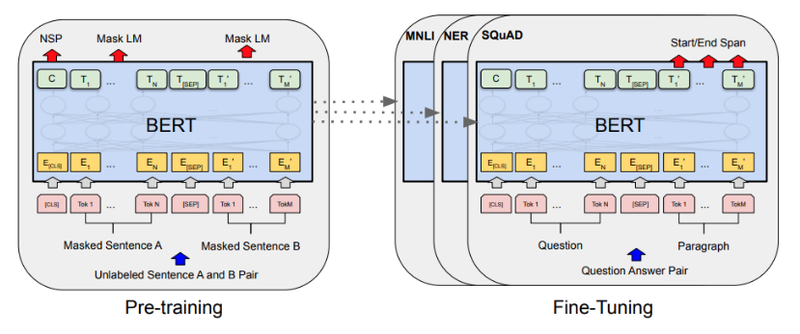
- Transformer ModelÏóêÏÑú Transformer Encoder Íµ¨Ï°∞ÎßåÏùÑ ÌôúÏö©   
- DecoderÍ∞Ä ÏóÜÎäîÎç∞ Ïñ¥ÎñªÍ≤å ÌïôÏäµÏãúÏºú..?   
    ‚áí BERTÏùò ÏûÖÎ†•ÏùÑ Transformer EncoderÏóê ÎÑ£ÏóàÏùÑ Îïå, Ï∂úÎ†• Î™®Îç∏Ïù¥¬†`Mask LM`,¬†`NSP`¬†ÎùºÎäî 2Í∞ÄÏßÄ Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌïòÎèÑÎ°ù ÎêòÏñ¥ ÏûàÏùå  
    
2. Token Embedding
- BERTÎäî ÌÖçÏä§Ìä∏Ïùò tokenizerÎ°ú Word Piece modelÏù¥ÎùºÎäî subword tokenizerÎ•º ÏÇ¨Ïö©
- Î¨∏Ïûê(char) Îã®ÏúÑÎ°ú ÏûÑÎ≤†Îî©ÌïòÎäî Í≤ÉÏù¥ Í∏∞Î≥∏, ÏûêÏ£º Îì±Ïû•ÌïòÎäî Í∏¥ Í∏∏Ïù¥Ïùò subwordÎèÑ ÌïòÎÇòÏùò Îã®ÏúÑÎ°ú ÎßåÎì§Ïñ¥ Ï§å
- ÏûêÏ£º Îì±Ïû•ÌïòÏßÄ ÏïäÎäî Îã®Ïñ¥Îäî Îã§Ïãú subword Îã®ÏúÑÎ°ú Ï™ºÍ∞úÏñ¥ OOV(Out-of-vocabulary) Ï≤òÎ¶¨ÎêòÎäî Í≤ÉÏùÑ Î∞©ÏßÄÌï¥ Ï§å

3. Segment Embedding
- TransformerÏóê ÏóÜÎçò ÎèÖÌäπÌïú ÏûÑÎ≤†Îî©
- Ïù¥Í≤ÉÏùÄ Í∞Å Îã®Ïñ¥Í∞Ä Ïñ¥Îäê Î¨∏Ïû•Ïóê Ìè¨Ìï®ÎêòÎäîÏßÄ Í∑∏ Ïó≠Ìï†ÏùÑ Í∑úÏ†ï
- QA Î¨∏Ï†úÏ≤òÎüº Ïù¥ Îã®Ïñ¥Í∞Ä Question Î¨∏Ïû•Ïóê ÏÜçÌïòÎäîÏßÄ, Context Î¨∏Ïû•Ïóê ÏÜçÌïòÎäîÏßÄ Íµ¨Î∂ÑÏù¥ ÌïÑÏöîÌïú Í≤ΩÏö∞Ïóê Îß§Ïö∞ Ïú†Ïö©

### <Î£®Î∏åÎ¶≠ ÌèâÍ∞Ä ÏßÄÌëúÎ•º ÎßûÏ∂îÍ∏∞ ÏúÑÌï¥ ÏãúÎèÑÌïú Í≤ÉÎì§>
1. pretrained modelÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Ìö®Ïú®ÏÑ±ÏùÑ ÏûÖÏ¶ùÌïòÍ≥†Ïûê ÌïòÏòÄÎã§.
2. epochÎ•º ÎäòÎ†§ ÏïàÏ†ïÏ†ÅÏù∏ Í≤∞Í≥ºÎ•º ÏñªÍ≥†Ïûê ÌïòÏòÄÎã§.
    => early stoppingÏúºÎ°ú ÏÉùÍ∞ÅÎ≥¥Îã§ ÏùºÏ∞ç ÎÅùÎÇ¨Îã§.

### <ÎßåÏïΩÏóê Î£®Î∏åÎ¶≠ ÌèâÍ∞Ä Í¥ÄÎ†® ÏßÄÌëúÎ•º Îã¨ÏÑ± ÌïòÏßÄ Î™ªÌñàÏùÑ Îïå, Ïù¥Ïú†Ïóê Í¥ÄÌïú Ï∂îÏ†ï>
ÏóÜÏùå

### <ÏûêÍ∏∞ Îã§Ïßê>
 NLP Ïó¥Ïã¨Ìûà ÌïòÏûê!!!!! Î∞∞Ïö∏Í≤å ÎÑàÎ¨¥ ÎßéÎãπ ÌôîÏù¥ÌÉ±„Öá

# Reference
1. AIFFEL LMS EXPLORATION 13
2. Ï∞®Ìä∏ Í∑∏Î¶¨Í∏∞ : https://jiwoncho20213135python.tistory.com/11